In [99]:
#import required libraries
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics
import warnings
from numpy import sqrt 
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import zero_one_loss
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel
from random import randrange


ModuleNotFoundError: No module named 'google.colab'

The purpose of the code bellow is to train, validate and tune multi-class ordinary classification models that can classify, given a set of surey responses by data scentist, what a survey's current yearly compensation bucket is. The code will include 
- Data Cleaning
- Exploratory data Analysis and feature selection
- Model implementation
- Model tuning
- Testing & Discussion

# 1. [1 pt] Data cleaning: 

In this section, we will load the data, and clean the data for easier utilization later in our analysis. In the analysis, we see that the feature are categorical and will need encoding to analyze it. This section will be done in the Exploratory data anaylis and feature selection instead of Data cleaning

In [ ]:
uploaded = files.upload()

In [2]:
#Use pandas to read clean_kaggle_data more easily
# # If files.upload() does not work, another option is to have the csv file to be in the same folder as the ipynb
warnings.filterwarnings("ignore")
df = pd.read_csv('clean_kaggle_data_2022.csv')
df.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


The following command creates a dictionnary mapping the header name to the question, and a dictionary for Q_29_Encoded - Q_29_bucket

In [3]:
dict_question = {} # Create dictionnary with header name and column
for index, column in enumerate(df):
    dict_question.update({column:(df.iloc[0,index])})
    

# Get a dictionary of values between the encoded target and the non encoded target
dict_target = df.set_index('Q29_Encoded').to_dict()['Q29_buckets']

#Remove 1 row 
df2 = df.iloc[1:, :] # Remove first row containing question

# Remove bucket column, avoid having two encoded columns later on
df2 = df2.iloc[:,:-1]

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 1 to 8136
Columns: 297 entries, Duration (in seconds) to Q29_Encoded
dtypes: float64(1), object(296)
memory usage: 18.4+ MB


In [5]:
df2.describe()

,Q29_Encoded
count,8136.000000
mean,3.760570
std,4.356735
min,0.000000
25%,0.000000
50%,2.000000
75%,7.000000
max,14.000000


In [6]:
print('The following are the number of null values per column')
df2.isnull().sum().sort_values(ascending=False).head(10) #Find any null values

The following are the number of null values per column


Q14_10    8114
Q36_13    8114
Q40_8     8114
Q42_5     8110
Q37_9     8107
Q40_11    8104
Q40_5     8101
Q41_7     8100
Q36_10    8099
Q42_6     8097
dtype: int64

From the results above, it can be seen that multiple features have a lot of missing data. There are different approach in handling columns with too many missing values. One approach was to remove any columns that has more than 70% missing data. This technique was suggested in this article:  https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/

In [7]:
limit = len(df2) * .3 # columns needs at least that number of non Na rows to stay
original_length = len(df2)
df2 = df2.dropna(thresh=limit, axis=1)

print(f'The number of features went from {len((df).axes[1])-1} to {len(df2.axes[1])-1} \n')

# Remove any rows if the target is null
df2 = df2.dropna(subset=['Q29_Encoded'])
new_length = len(df2)
print(f"The total number of rows now is {new_length} and the number of rows removed is {original_length-new_length}")

The number of features went from 297 to 48 

The total number of rows now is 8136 and the number of rows removed is 0


In [8]:
def calculate_unique_probability(column):
    '''
    Gets a table column and compute the probability distribution of each unique values
    
    Returns a dictionnary containing unique value and its probability
    '''
    dict_probability = {}
    probability = 0 # Set cummulatatif proability to 0
    
    #Get number of non na values
    rows_non_na = df2[column].count()
    
    #Loop through each unique values and calcualte the cumulatatif probability
    for unique in df2[column].unique():
        if unique == unique: #if value is Nan does not work                       
            probability += (df2[column].values == unique).sum()/rows_non_na
            dict_probability.update({unique:probability})
    
    return dict_probability
    
    
def change_Nan(df,column, dict_value_prob):
    '''
    The purpose of this function is to replace the Nan with one of the unique values. The Nan values 
    are replaced accordingly to the distribution of the unique values.    
    
    Input:
    ----------------------
    df = dataframe 
    column = string (column name)
    unique_value_prob = dictionary with cumulative probabiltiy for unique values
    ----------------------
    
    return dataframe with modified Nan values    
    '''
    last_key = list(dict_value_prob)[-1]
    
    for i in range(len(df2)):
        if df2[column].values[i] != df2[column].values[i]: # Return values that are nan
            random_value = random.random() # Get a random value between 0 and 1
            for key, value in dict_value_prob.items(): # Replace Nan with unique value based on probability
                if value > random_value:
                    df2[column].values[i] = key
                elif key == last_key:
                    df2[column].values[i] = key
    
    return df2                  

In [9]:
# Call function to replace Nan values
for column in df2.columns:
    if df2[column].isnull().sum() != 0:
        column_dict = calculate_unique_probability(column)
        df2 = change_Nan(df2,column,column_dict)

In [10]:
df2.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q7_2,Q7_4,Q7_5,Q8,...,Q38_7,Q39_11,Q40_14,Q41_8,Q42_1,Q43,Q44_4,Q44_6,Q44_8,Q29_Encoded
1,851,55-59,Man,France,No,Coursera,"Online courses (Coursera, EdX, etc)","Video platforms (YouTube, Twitch, etc)","Kaggle (notebooks, competitions, etc)",Some college/university study without earning ...,...,No / None,None,No / None,None,GPUs,2-5 times,"Kaggle (notebooks, forums, etc)","YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Blogs (Towards Data Science, Analytics Vidhya,...",2.0
2,501,30-34,Man,Germany,No,Coursera,"Online courses (Coursera, EdX, etc)","Video platforms (YouTube, Twitch, etc)","Kaggle (notebooks, competitions, etc)",Bachelor’s degree,...,No / None,None,No / None,None,GPUs,6-25 times,"Kaggle (notebooks, forums, etc)","YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Blogs (Towards Data Science, Analytics Vidhya,...",10.0
3,787,70+,Man,Australia,No,Coursera,"Online courses (Coursera, EdX, etc)","Video platforms (YouTube, Twitch, etc)","Kaggle (notebooks, competitions, etc)",Doctoral degree,...,No / None,None,No / None,None,GPUs,Never,"Kaggle (notebooks, forums, etc)","YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Blogs (Towards Data Science, Analytics Vidhya,...",10.0
4,1132,40-44,Man,United States of America,No,Coursera,"Online courses (Coursera, EdX, etc)","Video platforms (YouTube, Twitch, etc)","Kaggle (notebooks, competitions, etc)",Doctoral degree,...,No / None,None,No / None,None,GPUs,2-5 times,"Kaggle (notebooks, forums, etc)","YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Blogs (Towards Data Science, Analytics Vidhya,...",13.0
5,679,40-44,Man,United States of America,No,Coursera,"Online courses (Coursera, EdX, etc)","Video platforms (YouTube, Twitch, etc)","Kaggle (notebooks, competitions, etc)",Master’s degree,...,No / None,None,No / None,None,GPUs,More than 25 times,"Kaggle (notebooks, forums, etc)","YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Blogs (Towards Data Science, Analytics Vidhya,...",13.0


Looking at the table above, we can see that the null values are gone. Howerver, it looks like some features only have 1 unique value. If this is the case, this feature would not bring any extra information in our prediction. Hence, if this is the case, the feature is removed. 

In [11]:
# The code here removes any features that only has 1 unique value
count = 0 # initialize count, used to count how many features have been dropped

print("The following features are removed for having 1 unique value")

for i in df2.columns:
    if df2[i].nunique() == 1:
        print(i)
        df2 = df2.drop(columns=i)
        count += 1
        
print(f'\nThere were {count} that had 1 unique values. Those features were dropped from the dataframe. The shape of the dataframe is now: {df2.shape}')

The following features are removed for having 1 unique value
Q5
Q6_1
Q7_2
Q7_4
Q7_5
Q12_1
Q12_3
Q13_4
Q13_11
Q14_1
Q14_2
Q15_1
Q15_2
Q17_1
Q17_2
Q17_3
Q18_1
Q18_2
Q18_3
Q21_9
Q28_1
Q28_2
Q28_3
Q37_12
Q38_7
Q39_11
Q40_14
Q41_8
Q42_1
Q44_4
Q44_6
Q44_8

There were 32 that had 1 unique values. Those features were dropped from the dataframe. The shape of the dataframe is now: (8136, 17)


We will print the name of every features to see if there's any we should remove

In [12]:
for i in df2.columns:
    print(i)

Duration (in seconds)
Q2
Q3
Q4
Q8
Q9
Q11
Q16
Q23
Q24
Q25
Q26
Q27
Q29
Q30
Q43
Q29_Encoded


We want to remove columnn Q29 as it is the feature we want to predict and duration in seconds as it was not part of the dataset and I am not interested in this metric.

In [13]:
df2 = df2.drop('Q29',axis=1)
df2 = df2.drop("Duration (in seconds)",axis =1)
df2.head()

,Q2,Q3,Q4,Q8,Q9,Q11,Q16,Q23,Q24,Q25,Q26,Q27,Q30,Q43,Q29_Encoded
1,55-59,Man,France,Some college/university study without earning ...,No,10-20 years,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","$1000-$9,999",2-5 times,2.0
2,30-34,Man,Germany,Bachelor’s degree,No,10-20 years,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...",$0 ($USD),6-25 times,10.0
3,70+,Man,Australia,Doctoral degree,Yes,20+ years,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...",$100-$999,Never,10.0
4,40-44,Man,United States of America,Doctoral degree,Yes,10-20 years,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...",$100-$999,2-5 times,13.0
5,40-44,Man,United States of America,Master’s degree,Yes,10-20 years,5-10 years,Data Scientist,Computers/Technology,"1000-9,999 employees",3-4,"We have well established ML methods (i.e., mod...","$100,000 or more ($USD)",More than 25 times,13.0


In [14]:
''' Label coding is one way to encode categorical data.
If the number of unique value for each value columns is low, it is a possible method 
'''
df2.nunique().sort_values(ascending=False).head() # Count the number of unique values per column

Q4             58
Q24            15
Q29_Encoded    15
Q23            14
Q2             11
dtype: int64

Since there are many features, it can be hard to find all the categorical columns (all columns are string type). Hence, an algorithm will be used to determine if the column has categorical data based on duplicates. The algorithm consists of considering a feature categorical if the (total amount of rows - number of unique values)/total rows)*100 > 0.9 https://jeffreymorgan.io/articles/identifying-categorical-data/

In [15]:
def categorical_column(df):
    '''
    The purpose of this function is to determine if a column is composed of categorical data or not. The alogrithm 
    counts the number of unique value compared to the size of the data. The algorithm used was found here: 
    https://jeffreymorgan.io/articles/identifying-categorical-data/
    
    Input:
    ----------------------
    df = dataframe (one column)    
    ----------------------
    
    return boolean (return wether the column is categorical (True) or Numerical)     
    '''
    
    rows = len(df2) # returns number of rows in column
    unique_value_count = df.nunique() # get number of unique values in column
    
    difference = (rows - unique_value_count)/rows # Get the difference between total rows and number of unique values
    if difference > 0.9:
        return True
    else:
        return False

In [16]:
#Loop through each cloumn to verify if they are composed of categorical data

categorical_column_list = [] #Initialize list that contains categorical values

for i in df2.columns:   
    if i != 'Q29_Encoded': # Don't encode Q29 columns
        categorical = categorical_column(df2[i]) # Return True if column is categorical
        if categorical == True:
            categorical_column_list.append(i) # Append column name to list
            
# Remove duration in seconds         
            


In [17]:
#https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/ (label encoding vs hot one encoding)
#Label Encode features

#Encode table both methods and see which one we'll use later on

#Label Encoder
df_encoded = df2.copy()
le = LabelEncoder()
df_encoded[categorical_column_list] = df_encoded[categorical_column_list].apply(le.fit_transform)
print(f'The shape of df_encoded is: {df_encoded.shape}')

# Hot one encoded 
df_hot_encoded = df2
df_hot_encoded = pd.get_dummies(df_hot_encoded,columns=categorical_column_list)
print(f'The shape of df_encoded is: {df_hot_encoded.shape}')


The shape of df_encoded is: (8136, 15)
The shape of df_encoded is: (8136, 157)


We can see that only the column Duration (in seconds) was not encoded. Also, this question was not part of the dataset. Hence, we'll remove this colum. 

# [3 pts] Exploratory data analysis and feature selection

In this section, we will do some exploratory data to understand a bit more the dataset. Then, we'll perform some feature engineering method for the feature selection such as random forest, and we'll observe the correlations between features using a correlation heat map

The dictionary of question and targets are printed below to help understand this section

In [18]:
# Print the question asked for each features
for key, value in dict_question.items():
    if key in df2.columns:
        print(f'{key} - {value}')   

Q2 - What is your age (# years)?
Q3 - What is your gender? - Selected Choice
Q4 - In which country do you currently reside?
Q8 - What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Q9 - Have you ever published any academic research (papers, preprints, conference proceedings, etc)?
Q11 - For how many years have you been writing code and/or programming?
Q16 - For how many years have you used machine learning methods?
Q23 - Select the title most similar to your current role (or most recent title if retired): - Selected Choice
Q24 - In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
Q25 - What is the size of the company where you are employed?
Q26 - Approximately how many individuals are responsible for data science workloads at your place of business?
Q27 - Does your current employer incorporate machine learning methods into their business?
Q30 - Approximately how much 

In [19]:
dict_target

{nan: nan,
 2.0: '20,000-29,999',
 10.0: '100,000-124,999',
 13.0: '200,000-299,999',
 12.0: '150,000-199,999',
 9.0: '90,000-99,999',
 3.0: '30,000-39,999',
 0.0: '0-9,999',
 5.0: '50,000-59,999',
 11.0: '125,000-149,999',
 1.0: '10,000-19,999',
 8.0: '80,000-89,999',
 14.0: '>300,000',
 7.0: '70,000-79,999',
 6.0: '60,000-69,999',
 4.0: '40,000-49,999'}

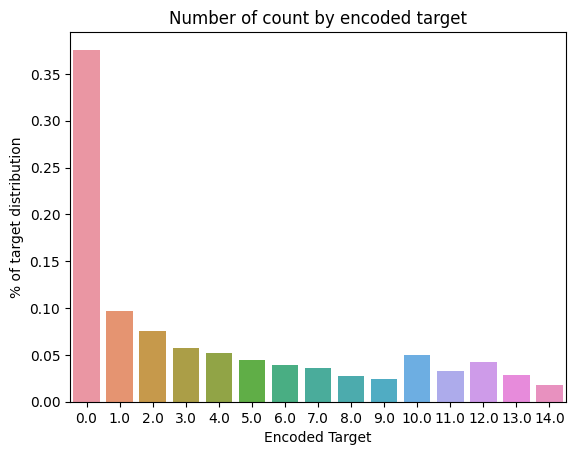

In [20]:
# We want to see the distribution of the target.
target = []
target_count = []


total_rows = len(df2)


for i in df2['Q29_Encoded'].unique():
    target.append(i)
    target_count.append((df2['Q29_Encoded'].value_counts()[i])/total_rows)

sns.barplot(x = target,y = target_count)
plt.title('Number of count by encoded target')
plt.xlabel('Encoded Target')
plt.ylabel('% of target distribution')
plt.show()

From the graph above, we can see that we have an imbalanced class distribution. We we'll keep this in mind during our analysis. Most participants are in the bucket 0, which represents a yearly compensation of 0-9999$ (target 0)

### Plot Distribution for interested features

In [21]:
def plot_distribution(df,feature,xlab,ylabl,title,xrot = 0):
    plt.figure(figsize=(10,10))
    plot = sns.countplot(x=feature,data=df)

    plot.tick_params(labelsize= 15)
    plt.xticks(rotation=xrot)
    plot.set_xlabel(xlab, size = 20)
    plot.set_ylabel(ylabl, size = 20)
    plot.set_title(title,size = 30)

    plt.tight_layout()
    plt.show()

I was interested in seeing the distribution answers for the following groups:
- Q2 (Age Groups)
- Q3 (Gender)
- Q8 Highest Education Level
- Q11 (Programming Years)
- Q23 (Job Title)

It would be easy to investigate other features by simply calling the plot_distribution function

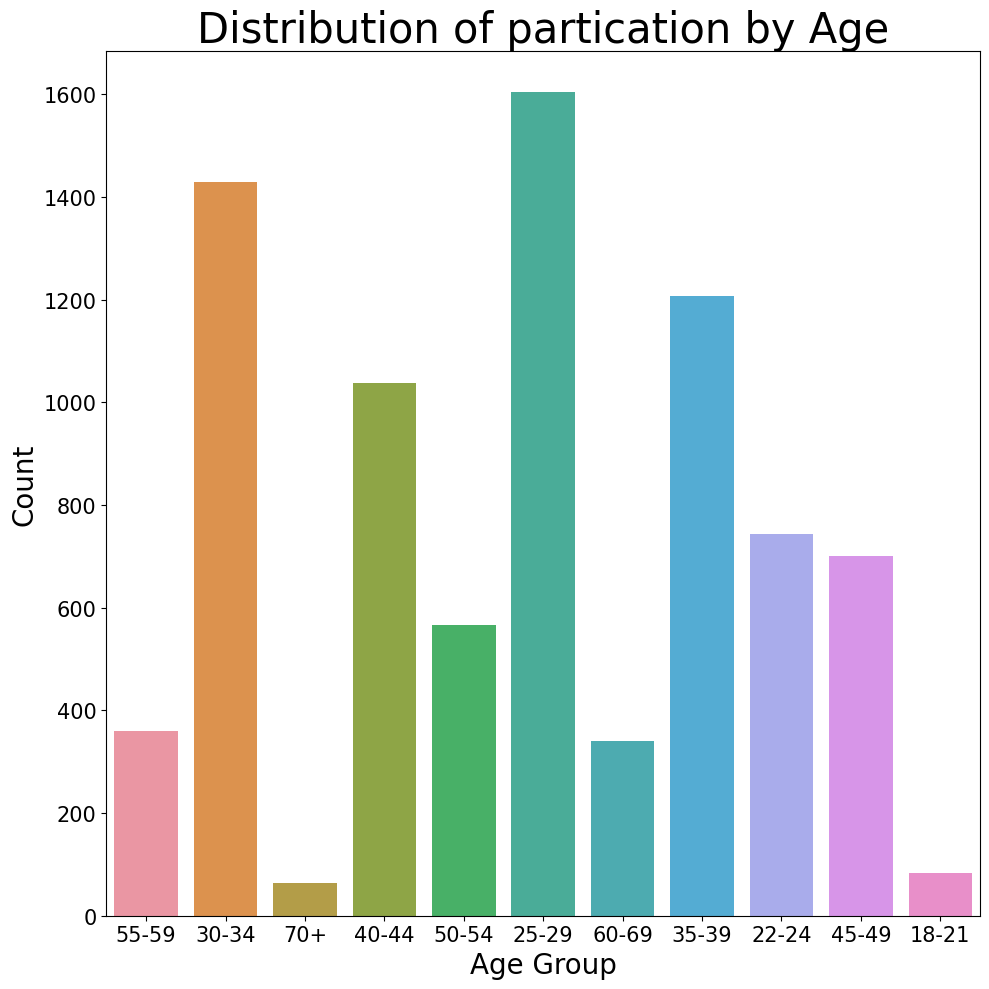

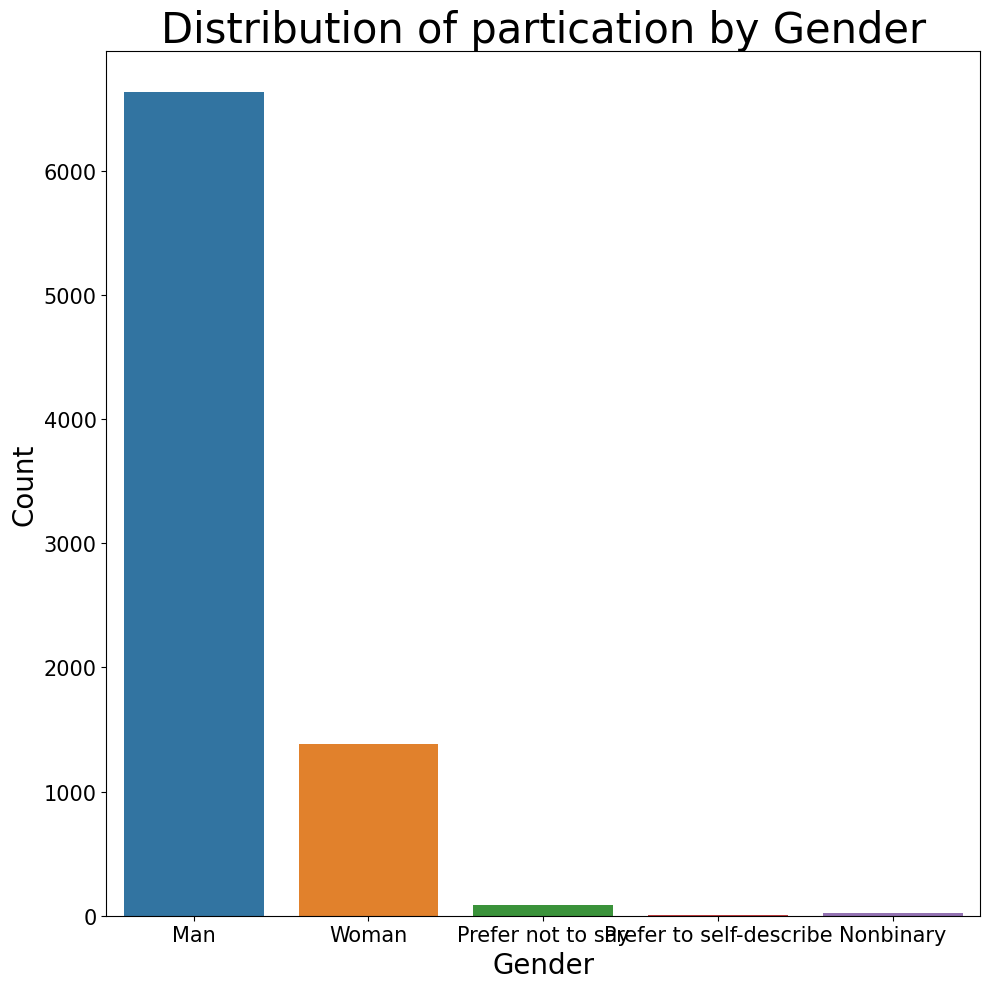

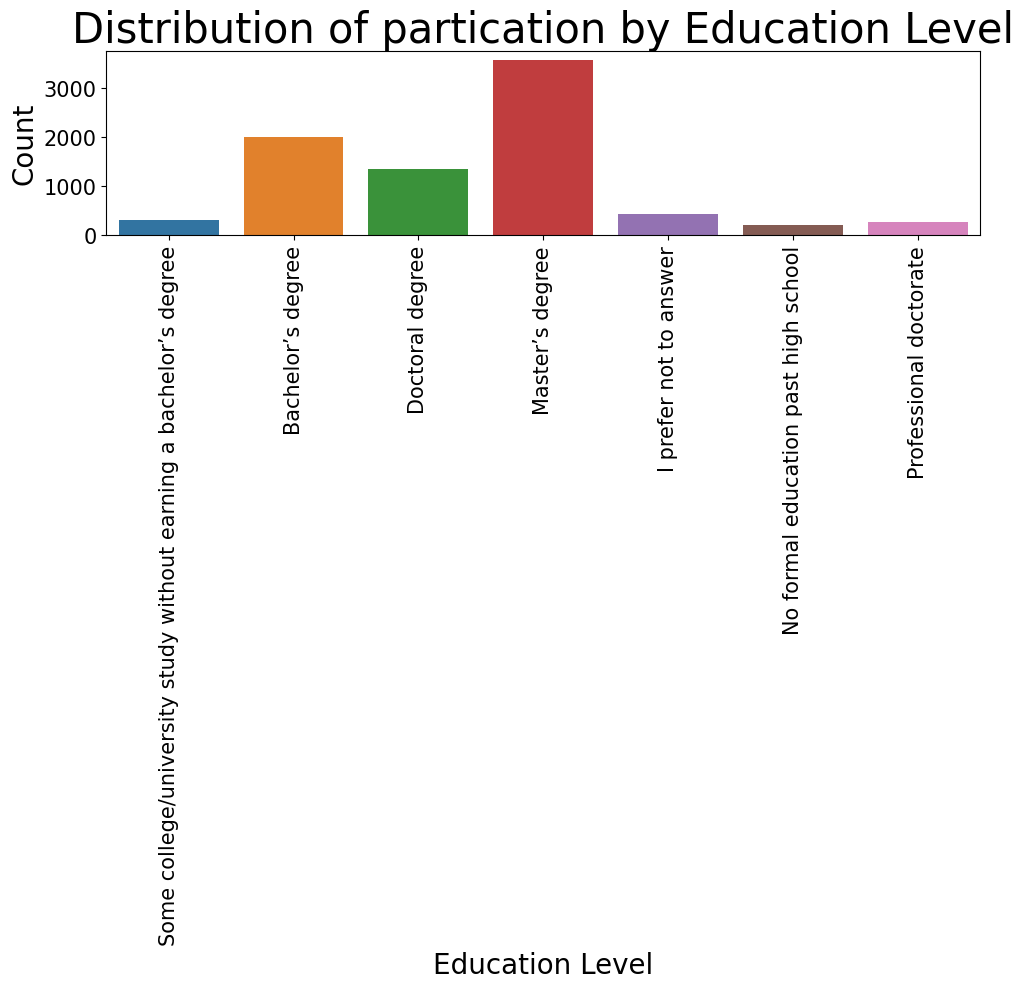

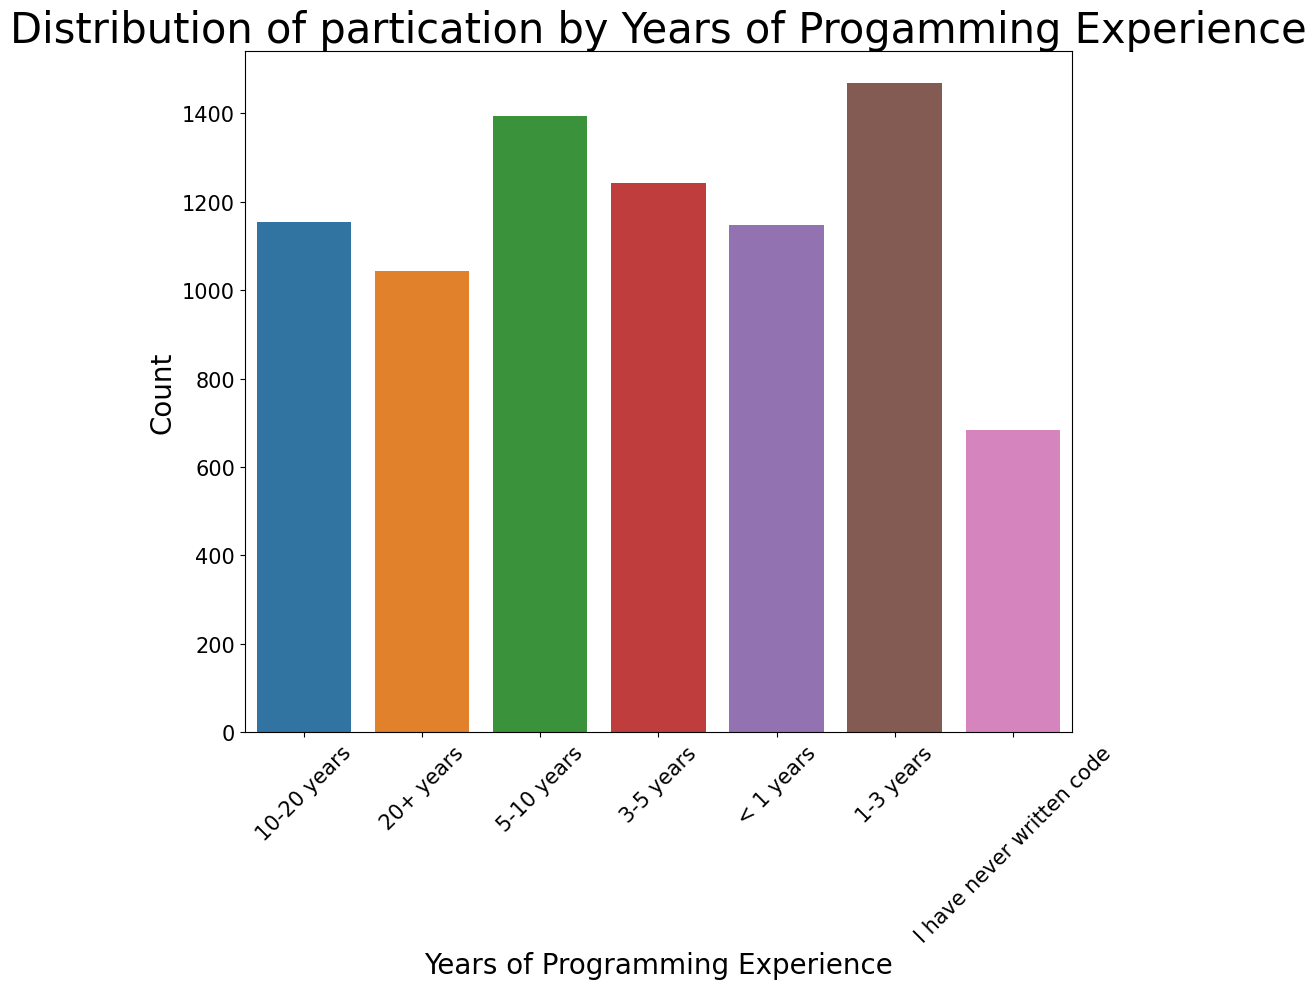

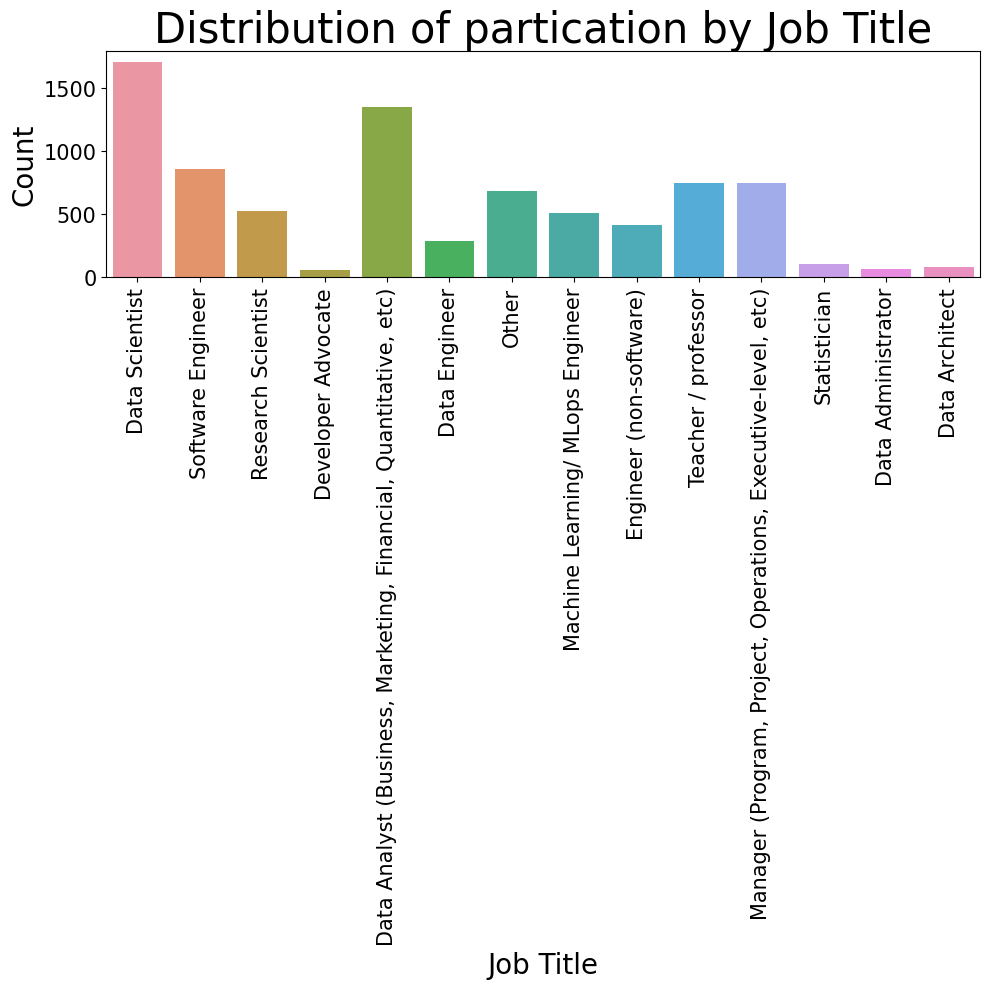

In [22]:
# Plot Distribution of interested graphs
plot_distribution(df2,"Q2","Age Group","Count","Distribution of partication by Age") 
plot_distribution(df2,"Q3","Gender","Count","Distribution of partication by Gender") 
plot_distribution(df2,"Q8","Education Level","Count","Distribution of partication by Education Level",xrot=90)
plot_distribution(df2,"Q11","Years of Programming Experience","Count","Distribution of partication by Years of Progamming Experience",xrot=45)
plot_distribution(df2,"Q23","Job Title","Count","Distribution of partication by Job Title",xrot = 90)



We can see tat most participants from the dataset were in the following groups:
- most participant between 25 and 55
- Far more man than woman
- Masters, Bachelors, Doctorate (highest to lowest participation) followed by other answers
- Distribution is pretty uniform for coding experience between 1-20+ years, smaller group never coded
- Data Scientist, Data Anslysit, Softwared Engineer (highest to lowest participation) followed by other answers

In [23]:
# Function that is used throughout the analysis to split tables into training and testing set
def test_train_data(df,target):
    '''
    Input:
    df: data frame to be split
    target: column name (string)
    Output:
    4 dataframe X_train, y_train, X_test, y_test
    '''
    X = df.drop(target, axis = 1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)   

    return X_train, y_train, X_test, y_test

## Feature Selection

The following graph shows the relationship between features. Since the features are categorical, the label encoder table was used. The logic behind it was that if the hot one table was used, the correlation map would be too big to give a lot of information. This one gives a better high level view between each questions

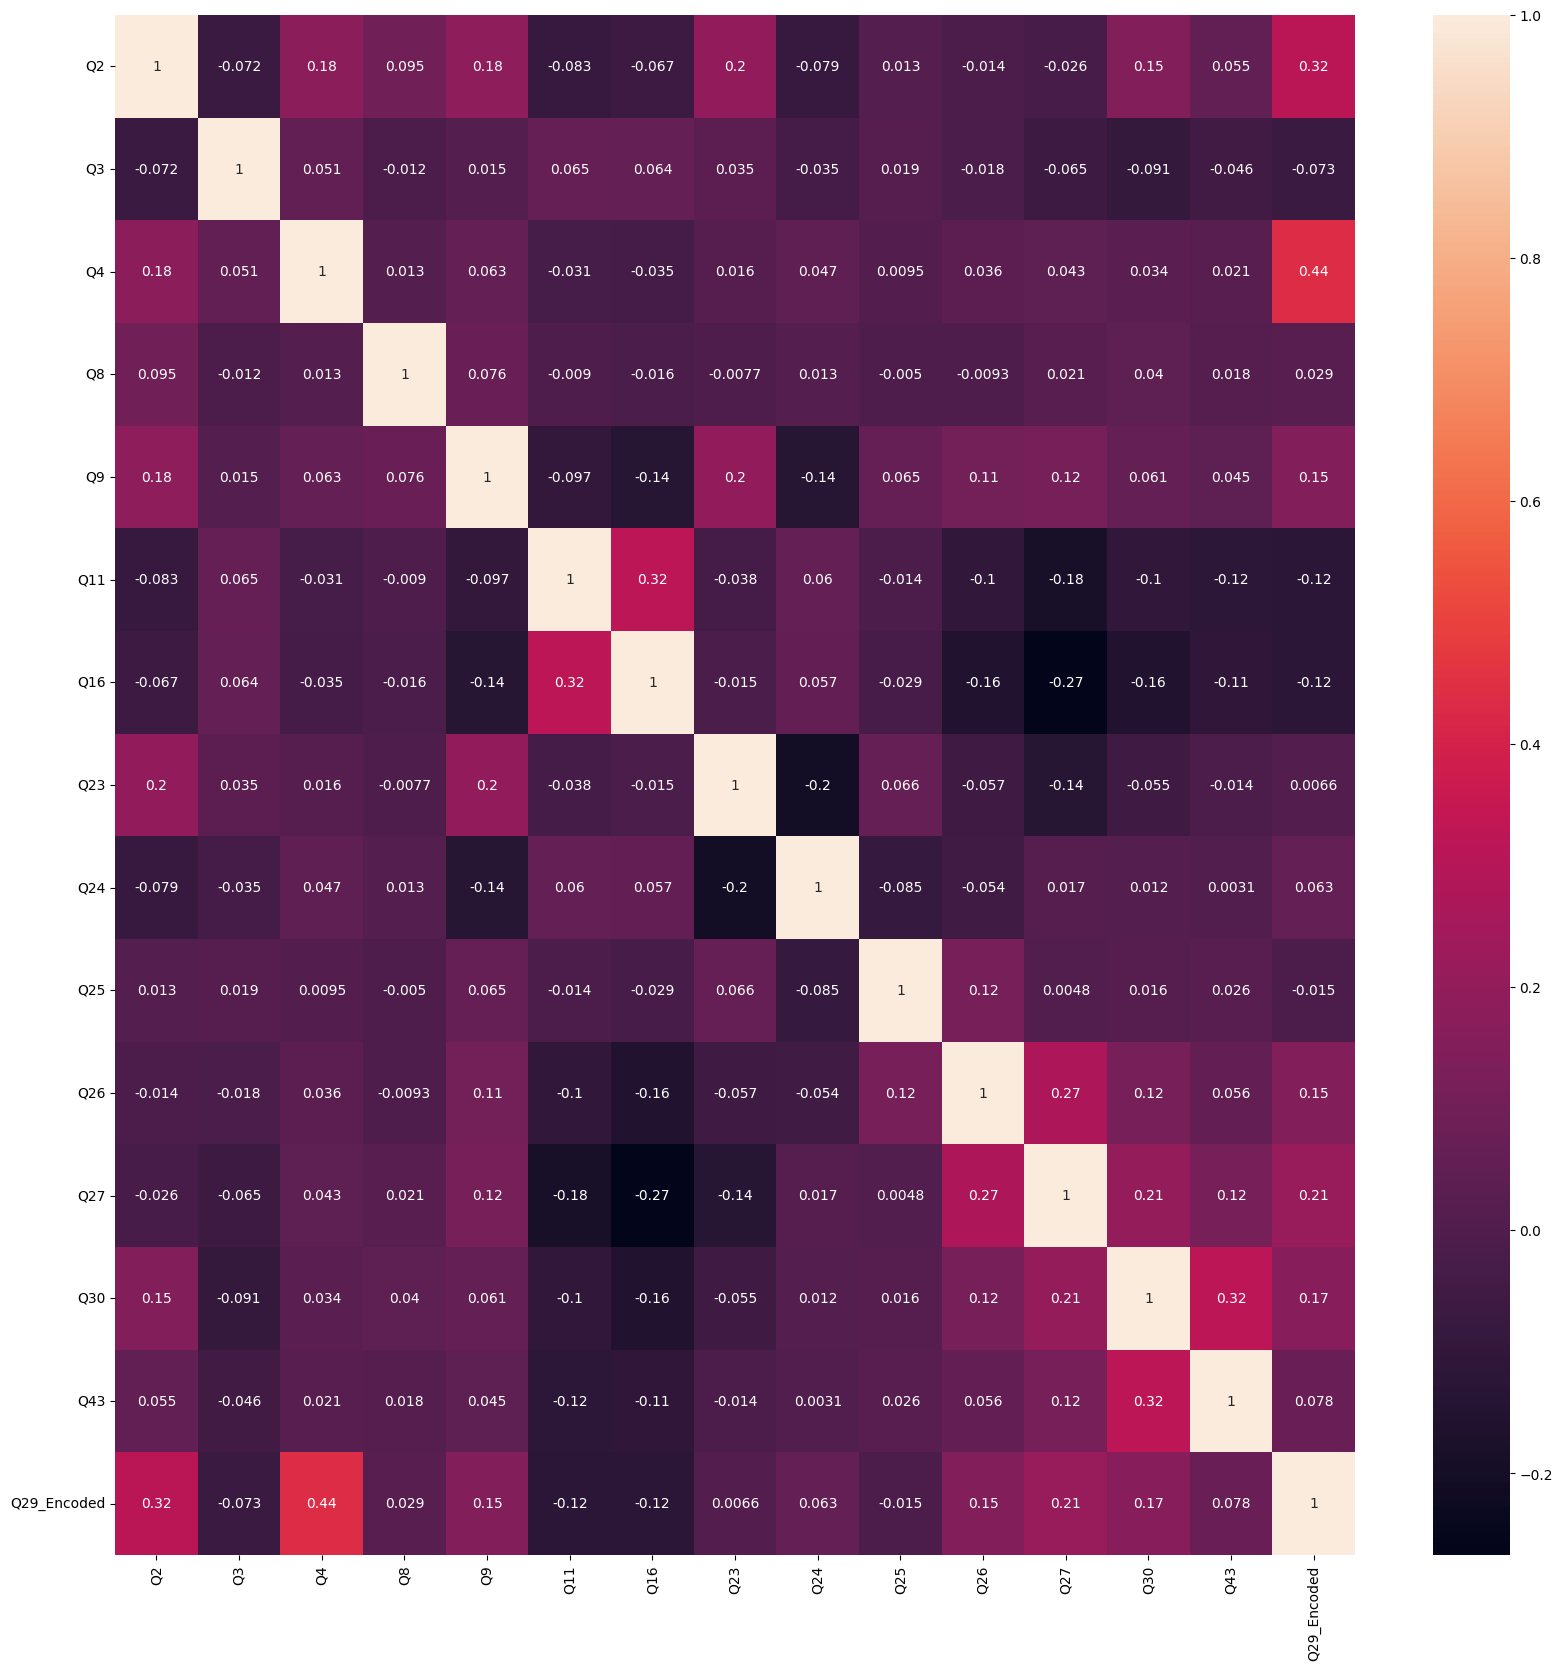

In [24]:
#Plot correlation heat map for features

cmap = sns.diverging_palette(145, 280, s=85, l=25, n=7)
sns.heatmap(df_encoded.corr(),annot=True)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

From the heatmap, we can see that the feature the most positively correlated to the target is Q4 ( Country ) with 0.44 and the most negatively correlated to the target is Q11 and Q16 (years of writting code, years of using machine learning methods)with -0.12. We can also see that the feature that is most correlated to the compensation feature is Q27 (Does your current employer incorporate machine learning methods into their business?), with a correlation of 0.21. 

The purpose of this heatmap was to quickly visualize the correlation between features. If there was a highly corelated feature above 0.9, it would've been removed as it could lead to overfitting since the model can't distinguish between highly correlated features by using them to train. https://www.kaggle.com/questions-and-answers/216451

A perfect example would be that I used Q29 as one of the feature and the accuracy kept giving 100%.

### Random Forest  

The feature seletion technique was Random Forest. This method was used since it is highly accurate, generalize better, and are easily interpretable, it gives a reasonable prediction without hyper-parameter tuning. This method also works for classification problems by using the gini impurity to get the importance of each features. https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

Documentation https://www.kaggle.com/questions-and-answers/216451

In [25]:
column_trans = ColumnTransformer(transformers=[('cat', OrdinalEncoder(), selector(dtype_include="object"))],remainder='drop')


# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')
pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

In [26]:
#Split the data into 20% test and 70% training
X_train_tree, y_train_tree, X_test_tree, y_test_tree = test_train_data(df2,'Q29_Encoded')
pipeline.fit(X_train_tree, y_train_tree)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA5ED09090>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [27]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(X_train_tree, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(X_train_tree, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 1.0


,FEATURE,IMPORTANCE,CUMSUM
2,Q4,0.117114,0.117114
8,Q24,0.098860,0.215974
0,Q2,0.093437,0.309411
7,Q23,0.087157,0.396567
6,Q16,0.076883,0.473450
10,Q26,0.073633,0.547083
9,Q25,0.073165,0.620248
5,Q11,0.071456,0.691705
12,Q30,0.069631,0.761335
11,Q27,0.068463,0.829799


### Plotting Random Forest Tree Results

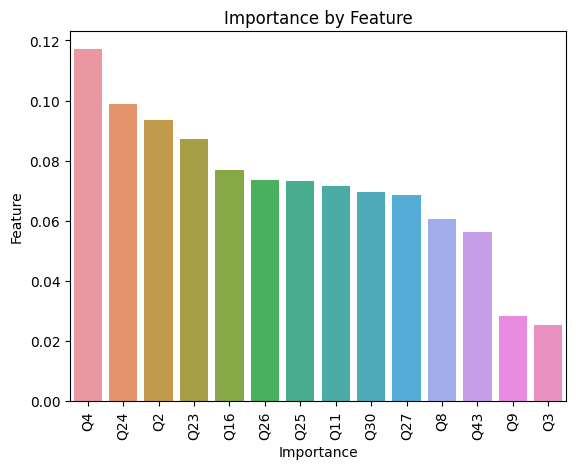

In [28]:
random_forest_plot = sns.barplot(x = df_imp['FEATURE'],y = df_imp['IMPORTANCE'])
random_forest_plot.set_xticklabels(df_imp['FEATURE'],rotation=90)
random_forest_plot.set_xlabel("Importance")
random_forest_plot.set_ylabel("Feature")
random_forest_plot.set_title("Importance by Feature")
plt.show()

In [29]:
print(f"The Most Important Features (gini importance > 0.05) are: \n {included_feats} \n There's {len(included_feats)} features:")

The Most Important Features (gini importance > 0.05) are: 
 ['Q2', 'Q4', 'Q8', 'Q11', 'Q16', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q30', 'Q43'] 
 There's 12 features:


In [30]:
# Verify accuracy (Make prediction with test set)
y_pred_train = pipeline.predict(X_train_tree)
y_pred_test = pipeline.predict(X_test_tree)
print(f'The accuracy score on the train set using the random forest tree is: {round(accuracy_score(y_train_tree, y_pred_train),3)}')
print(f'The accuracy score on the test set using the random forest tree is: {round(accuracy_score(y_test_tree, y_pred_test),3)}')

The accuracy score on the train set using the random forest tree is: 0.999
The accuracy score on the test set using the random forest tree is: 0.372


From the results above, we can see that the values are highly overfitted. However, for the purpose of this assignment, those features will be selected, but it is an area of improvement. One possible reason whhy the accuracy is not the best was that ordinal encoding was used but not all features are or ordinal values.

### Modify features

Further in this analysis, we want to use the features that we selected using feature engineering. Looking at the features that were selected, it can be seen that some features are ordinal (Q2 age) and some are not (Q4 Country). For simplicity, we will hot one encode all features. However, if the model wants to be improved, the following steps can be made (take the features that are ordinal and use ordinal encoding, take the categorical features that are not ordinal and one hot encode them). Merge the table together and after you can apply the required algorithms. If this method is used, it is important to modify the table accordingly to the algortim since OHE are 0-1 values but using label encoding will give 0-(n-1) values

In [31]:
#Based on the result obtained from the feature selection algorithm (random forest), we'll only keep certain features
#Adding target to dataframe
included_feats.append('Q29_Encoded')
df3 = df2[included_feats]

# Verify how many unique value each features has
for i in df3.columns:
    print(f"{i} feature has {df3[i].nunique()} unique values and is type {df3[i].dtype}")


Q2 feature has 11 unique values and is type object
Q4 feature has 58 unique values and is type object
Q8 feature has 7 unique values and is type object
Q11 feature has 7 unique values and is type object
Q16 feature has 8 unique values and is type object
Q23 feature has 14 unique values and is type object
Q24 feature has 15 unique values and is type object
Q25 feature has 5 unique values and is type object
Q26 feature has 7 unique values and is type object
Q27 feature has 6 unique values and is type object
Q30 feature has 6 unique values and is type object
Q43 feature has 5 unique values and is type object
Q29_Encoded feature has 15 unique values and is type float64


In [32]:
encoded_feature = included_feats
encoded_feature.remove('Q29_Encoded') # We don't want to encode the target

# OHE dataset
df3_OHE = df3.copy()

#Don't want to encode target
df3_OHE = pd.get_dummies(df3_OHE,columns=encoded_feature)


In [33]:
df3_OHE.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,2.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,10.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,10.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,13.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,13.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [34]:
df3_OHE.shape

(8136, 150)

PCA is a method that can be applied if there's too many features. In our case, since the dimensions were (813,150) it was decided that PCA was not required. However, this could be an area of improvement. PCA might lead to higher performance later in our model.

# 4 Model Implementation

In this section we will use ordinal logistic regression on the training data using 10 fold cross validation. We will see how the model accuracy compare accross folds and its variance. We will tune one hyperparameter using bias - tradeoff as the decision maker. We will also output the the probabiltiy for each bucket that the model estimates

The functions underneath is used to calculate the model using cross validation, the bias and variance.

In [35]:
def bias_fun(y_pred,y):
    y_pred = np.array(y_pred)
    y = np.array(y)
    return np.mean(np.power((y_pred-y),2))

def variance_fun(y_pred):
    y_pred = np.array(y_pred)
    return np.var(y_pred)

In [36]:
def cross_validation(model,df,X,y,show_predictions = True,show_accuracy = True, show_error = True):
    '''
    Function to output accuracy ofr each fold of model and its variance. The default values of LogisticRression are used
    but will be tested with different ones.
    
    Input:
    model
    show_prediction: Boolean (if set to True, show the predictions for each buckets)
    show_accuracy: Boolean (if set to True, show the accuracy for each folds and the average accuracy)
    '''    
    
    fold_outcome = []
    bias_outcome = []
    variance_outcome = []
    y_pred_list = np.array([]) # will store all y predictions for each fold
    kfold = 10
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    i = 1

     
    for train_index, test_index in kf.split(df):
        
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]

        #Fit the model        
        model.fit(X_train, y_train) #Training the model        
        y_pred = model.predict(X_test)
        
        y_pred_list = np.append(y_pred_list,y_pred)
        bias = bias_fun(y_test,y_pred)
        var = variance_fun(y_pred)
        bias_outcome.append(bias)
        variance_outcome.append(var)
        fold_outcome.append(accuracy_score(y_test, y_pred))
        
        if show_accuracy == True:
            print(f"Accuracy for the fold no. {i} on the test set: {100*(round(accuracy_score(y_test, y_pred),3))} %")
    
        i += 1
    
    average_accuracy = np.mean(fold_outcome)
    std_accuracy = np.std(fold_outcome)
        
    bias_average = np.mean(bias_outcome)
    variance_average = np.mean(variance_outcome)
    total_error = bias_average + variance_average
    y_pred_list = np.asarray(y_pred_list)
    
    if show_accuracy == True:
        print(f'The average accuracy accross folds is: {100 * (round(average_accuracy,3))} % with a standard deviation of {(round(std_accuracy,3))}\n')  
    
    if show_error == True:
        print(f"The average bias is {round(bias_average,3)}")
        print(f"The average variance is {round(variance_average,3)}")
        print(f"The total average error is {round(total_error,3)}")
    
    # Output probability of predictions for each bucket
    if show_predictions == True:
        unique, counts = np.unique(y_pred_list, return_counts = True)
        prediction_dict = dict(zip(unique, counts))
        print("The following is the estimated probability for each target bucket")
        for k,v in prediction_dict.items():
            probability = (v/len(y_pred_list)) * 100
            print(f"bucket {k} is: {round(probability,3)}%")
    
    return bias_average, variance_average, total_error
    

## Model Implementation using Logistic Regression (multiclass = 'ovr')

### Ordinal Logistic Regression (Default values)

## Important Note underneath

It is to note that this model was used originally, but later found it is not exactly an ordinal logistic regression. This method is not exactly a ordinal logistc regression as the Ovr is training a binary model for each class fitted against all other classes.

In [37]:
model = LogisticRegression(multi_class="ovr")
X = df3_OHE.drop('Q29_Encoded', axis=1)
y = df3_OHE['Q29_Encoded']
bias_average, variance_average, total_error = cross_validation(model,df3_OHE,X,y,show_predictions=True,show_accuracy=True, show_error = True)

Accuracy for the fold no. 1 on the test set: 38.5 %
Accuracy for the fold no. 2 on the test set: 39.900000000000006 %
Accuracy for the fold no. 3 on the test set: 41.4 %
Accuracy for the fold no. 4 on the test set: 41.0 %
Accuracy for the fold no. 5 on the test set: 40.8 %
Accuracy for the fold no. 6 on the test set: 40.0 %
Accuracy for the fold no. 7 on the test set: 42.1 %
Accuracy for the fold no. 8 on the test set: 39.0 %
Accuracy for the fold no. 9 on the test set: 43.4 %
Accuracy for the fold no. 10 on the test set: 42.8 %
The average accuracy accross folds is: 40.9 % with a standard deviation of 0.015

The average bias is 12.165
The average variance is 19.128
The total average error is 31.293
The following is the estimated probability for each target bucket
bucket 0.0 is: 65.02%
bucket 1.0 is: 3.355%
bucket 2.0 is: 2.593%
bucket 3.0 is: 2.655%
bucket 4.0 is: 3.183%
bucket 5.0 is: 2.397%
bucket 6.0 is: 0.959%
bucket 7.0 is: 1.438%
bucket 8.0 is: 0.651%
bucket 9.0 is: 0.578%
bucke

##  Choosing best hyperparameter (Bias - Variance)

In the section of choosing the best hyperparameter, we will only look at the total error using Bias Variance decomposition. We won't display the accuracy of each folds and the prediction.

We will choose multiple values for one specific hyperparameter and choose the one wih the lowest Bias - Variance. We will test the best solver,penalty,and regularization strength (C) based on the error.

### Choosing the best solver 

In [38]:
# Possible solver regularization strength 
C_list = [0.00001,0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1] 
bias_C_list = [] # Used for plotting
var_C_list = [] # Used for plotting
error_C_list = [] # Used for plotting
smallest_error = float('inf')
X = df3_OHE.drop('Q29_Encoded', axis=1)
y = df3_OHE['Q29_Encoded']

# Calculate total loss for each penalties hyperparameter
for i,C in enumerate(C_list):
    print(f"The summary for solver {C} is the following:")
    model=LogisticRegression(multi_class="ovr",C=C)
    bias_C_average, variance_C_average, total_C_error = cross_validation(model,df3_OHE,X,y,show_predictions=False,show_accuracy=False,show_error=False)
    bias_C_list.append(bias_C_average)
    var_C_list.append(variance_C_average)
    error_C_list.append(total_C_error)
    print(f"Total error = {round(total_C_error,3)}\nBias = {round(bias_C_average,3)}\nVariance = {round(variance_C_average,3)}\n")
    
    # update best hyperparameter
    if total_error < smallest_error:
        smallest_error = total_error
        smallest_error_index = i
        
print(f"\nThe best C value is {C_list[smallest_error_index]}")
best_C_val = C_list[smallest_error_index] # Use for next hyperparameter selection

The summary for solver 1e-05 is the following:
Total error = 33.121
Bias = 33.121
Variance = 0.0

The summary for solver 0.0001 is the following:
Total error = 33.121
Bias = 33.121
Variance = 0.0

The summary for solver 0.001 is the following:
Total error = 33.121
Bias = 33.121
Variance = 0.0

The summary for solver 0.005 is the following:
Total error = 32.822
Bias = 24.95
Variance = 7.873

The summary for solver 0.01 is the following:
Total error = 33.297
Bias = 20.497
Variance = 12.8

The summary for solver 0.05 is the following:
Total error = 32.494
Bias = 15.455
Variance = 17.039

The summary for solver 0.1 is the following:
Total error = 31.94
Bias = 13.933
Variance = 18.008

The summary for solver 0.5 is the following:
Total error = 31.335
Bias = 12.479
Variance = 18.856

The summary for solver 1 is the following:
Total error = 31.293
Bias = 12.165
Variance = 19.128


The best C value is 1e-05


### Choosing best solver

In [39]:
# Possible solver 
solver_list = ['newton-cg','lbfgs','liblinear','sag'] #Solver saga caused an issue so we won't take it
bias_solver_list = [] # Used for plotting
var_solver_list = [] # Used for plotting
error_solver_list = [] # Used for plotting
smallest_error = float('inf')
X = df3_OHE.drop('Q29_Encoded', axis=1)
y = df3_OHE['Q29_Encoded']

# Calculate total loss for each penalties hyperparameter
for i, solver in enumerate(solver_list):
    print(f"The summary for solver {solver} is the following:")
    model=LogisticRegression(multi_class="ovr",solver=solver)
    bias_solver_average, variance_solver_average, total_error = cross_validation(model,df3_OHE,X,y,show_predictions=False,show_accuracy=False,show_error=False)
    bias_solver_list.append(bias_solver_average)
    var_solver_list.append(variance_solver_average)
    error_solver_list.append(total_error)
    print(f"Total error = {total_error}\nBias = {bias_solver_average}\nVariance = {variance_solver_average}\n")
    
    # update best hyperparameter
    if total_error < smallest_error:
        smallest_error = total_error
        smallest_error_index = i
        
print(f"\nThe best solver is {solver_list[smallest_error_index]}")
best_solver = solver_list[smallest_error_index] # Use for next hyperparameter selection

The summary for solver newton-cg is the following:
Total error = 31.29000719669475
Bias = 12.164640772943354
Variance = 19.125366423751395

The summary for solver lbfgs is the following:
Total error = 31.292527284626253
Bias = 12.164763774173368
Variance = 19.127763510452887

The summary for solver liblinear is the following:
Total error = 31.34681276506781
Bias = 12.17522839847563
Variance = 19.171584366592178

The summary for solver sag is the following:
Total error = 31.290945364748016
Bias = 12.177063897174598
Variance = 19.113881467573417


The best solver is newton-cg


## Probability for each buckets

In [40]:
# We will test the following penalties for the Logistic Regression
penalties_list = ['l1', 'l2'] # elasticnet and none were causing issues
bias_penalty_list = [] # Used for plotting
var_penalty_list = [] # Used for plotting
error_penalty_list = [] # Used for plotting
smallest_error = float('inf')
X = df3_OHE.drop('Q29_Encoded', axis=1)
y = df3_OHE['Q29_Encoded']

# Calculate total loss for each penalties hyperparameter
for i, penalty in enumerate(penalties_list):
    print(f"The summary for penalty {penalty} is the following:")
    model=LogisticRegression(multi_class="ovr",penalty=penalty,solver='saga') #Using saga as it can try the most penalties
    bias_penalty_average, variance_penalty_average, total_error = cross_validation(model,df3_OHE,X,y,show_predictions=False,show_accuracy=False,show_error=False)
    bias_penalty_list.append(bias_penalty_average)
    var_penalty_list.append(variance_penalty_average)
    error_penalty_list.append(total_error)
    print(f"Total error = {total_error}\nBias = {bias_penalty_average}\nVariance = {variance_penalty_average}\n")
    
    # update best hyperparameter
    if total_error < smallest_error:
        smallest_error = total_error
        smallest_error_index = i
        
print(f"\nThe best hyperparameter for the penalty is {penalties_list[smallest_error_index]}")
best_penalty = penalties_list[smallest_error_index] # Use for next hyperparameter selection
    

The summary for penalty l1 is the following:
Total error = 31.59672178411476
Bias = 12.256646297421206
Variance = 19.340075486693554

The summary for penalty l2 is the following:
Total error = 31.288665076262475
Bias = 12.165255779093417
Variance = 19.123409297169058


The best hyperparameter for the penalty is l2


### Plotting Bias - Variance for each hyperparameters

In [41]:
def plot_bias_var(bias,variance,error,hyperparam_list, hyperparam):
    '''
    Print plot the bias variance plot for each hyperparameters
    
    Input:
    bias : list containing bias for each hyperparameters
    variance : list containing variance for each hyperparameters
    hyperparam_list : list of all hyperparameters tested
    error : string of hyperparameter   
    '''
    
    plt.plot(hyperparam_list,bias, label='bias')
    plt.plot(hyperparam_list,variance, label = 'variance')
    plt.plot(hyperparam_list,error, label = 'total error')
    plt.xlabel(hyperparam)
    plt.ylabel("Bias Variance Decomposition")
    plt.title('Total error by hyperparameter')
    plt.legend()
    plt.show()
    

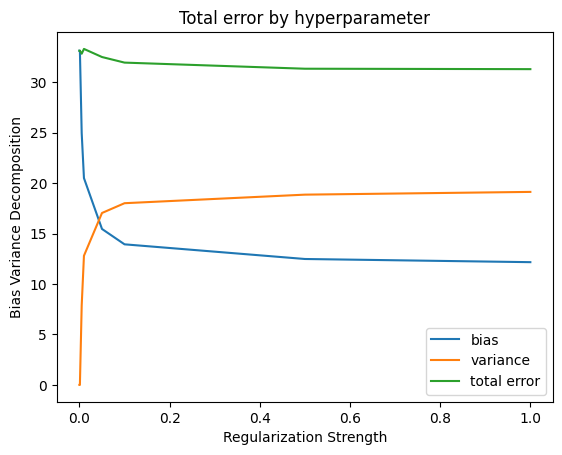

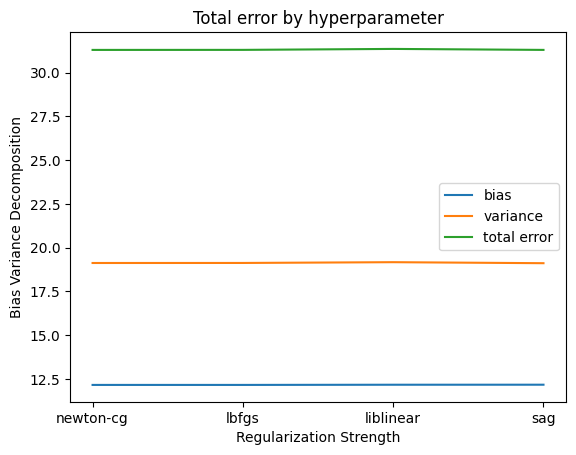

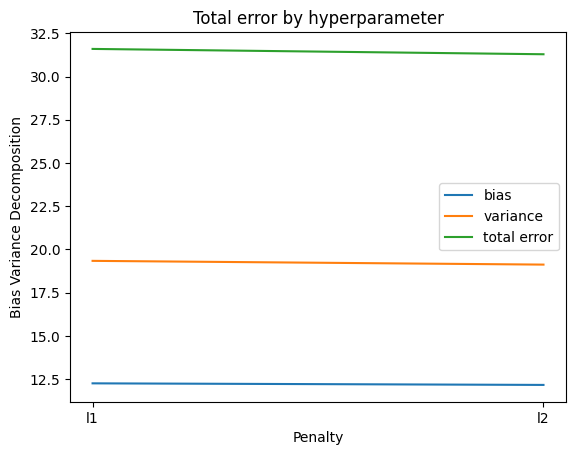

In [42]:
plot_bias_var(bias_C_list,var_C_list,error_C_list,C_list,"Regularization Strength")
plot_bias_var(bias_solver_list,var_solver_list,error_solver_list,solver_list,"Regularization Strength")
plot_bias_var(bias_penalty_list,var_penalty_list,error_penalty_list,penalties_list,"Penalty")

# Model Implementation sequence of binary logistic regression

# 4 [3pts] Model tuning:

## Cutting dataset in 14 groups

We will use proportional odds model for the Ordinal Logistic Regression like shown in class, we apply a sequence of binary logistic regression. Each time we cut the entire dataset, we compare the lower categories to higher categories. Since we have 15 targets (0-14), we create 14 tables. It is to note that the results were saved and displayed as markdown to avoid reruning the code everytime.

In [43]:
# We know that we have 15 classification 0-14
df01 = df3_OHE.copy()
count01 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=1):
        df01['Q29_Encoded'].iloc[i]=1
    else:
        df01['Q29_Encoded'].iloc[i]=0
        count01 += 1
print(count01)

3058


In [44]:
df01.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [45]:
# We know that we have 15 classification 0-14
df12 = df3_OHE.copy()
count12 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=2):
        df12['Q29_Encoded'].iloc[i]=1
    else:
        df12['Q29_Encoded'].iloc[i]=0
        count12 += 1
print(count12)

3850


In [46]:
df12.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [47]:
# We know that we have 15 classification 0-14
df23 = df3_OHE.copy()
count23 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=3):
        df23['Q29_Encoded'].iloc[i]=1
    else:
        df23['Q29_Encoded'].iloc[i]=0
        count23 += 1
print(count23)

4464


In [48]:
df23.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [49]:
# We know that we have 15 classification 0-14
df34 = df3_OHE.copy()
count34 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=4):
        df34['Q29_Encoded'].iloc[i]=1
    else:
        df34['Q29_Encoded'].iloc[i]=0
        count34 += 1
print(count34)

4928


In [50]:
df34.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [51]:
# We know that we have 15 classification 0-14
df45 = df3_OHE.copy()
count45 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=5):
        df45['Q29_Encoded'].iloc[i]=1
    else:
        df45['Q29_Encoded'].iloc[i]=0
        count45 += 1
print(count45)

5349


In [52]:
df45.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [53]:
# We know that we have 15 classification 0-14
df56 = df3_OHE.copy()
count56 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=6):
        df56['Q29_Encoded'].iloc[i]=1
    else:
        df56['Q29_Encoded'].iloc[i]=0
        count56 += 1
print(count56)

5715


In [54]:
df56.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [55]:
# We know that we have 15 classification 0-14
df67 = df3_OHE.copy()
count67 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=7):
        df67['Q29_Encoded'].iloc[i]=1
    else:
        df67['Q29_Encoded'].iloc[i]=0
        count67 += 1
print(count67)

6033


In [56]:
df67.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [57]:
# We know that we have 15 classification 0-14
df78 = df3_OHE.copy()
count78 = 0 
for i in range(len(df3_OHE)):
    if (df78['Q29_Encoded'].iloc[i]>=8):
        df78['Q29_Encoded'].iloc[i]=1
    else:
        df78['Q29_Encoded'].iloc[i]=0
        count78 += 1
print(count78)

6322


In [58]:
df78.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [59]:
# We know that we have 15 classification 0-14
df89 = df3_OHE.copy()
count89 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=9):
        df89['Q29_Encoded'].iloc[i]=1
    else:
        df89['Q29_Encoded'].iloc[i]=0
        count89 += 1
print(count89)

6544


In [60]:
df89.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [61]:
# We know that we have 15 classification 0-14
df910 = df3_OHE.copy()
count910 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=10):
        df910['Q29_Encoded'].iloc[i]=1
    else:
        df910['Q29_Encoded'].iloc[i]=0
        count910 += 1
print(count910)

6741


In [62]:
df910.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [63]:
# We know that we have 15 classification 0-14
df1011 = df3_OHE.copy()
count1011 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=11):
        df1011['Q29_Encoded'].iloc[i]=1
    else:
        df1011['Q29_Encoded'].iloc[i]=0
        count1011 += 1
print(count1011)

7145


In [64]:
df1011.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [65]:
# We know that we have 15 classification 0-14
df1112 = df3_OHE.copy()
count1112 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=12):
        df1112['Q29_Encoded'].iloc[i]=1
    else:
        df1112['Q29_Encoded'].iloc[i]=0
        count1112 += 1
print(count1112)

7414


In [66]:
df1112.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [67]:
# We know that we have 15 classification 0-14
df1213 = df3_OHE.copy()
count1213 = 0 
for i in range(len(df3_OHE)):
    if (df1213['Q29_Encoded'].iloc[i]>=13):
        df1213['Q29_Encoded'].iloc[i]=1
    else:
        df1213['Q29_Encoded'].iloc[i]=0
        count1213 += 1
print(count1213)

7756


In [68]:
df1213.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,1.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [69]:
# We know that we have 15 classification 0-14
df1314 = df3_OHE.copy()
count1314 = 0 
for i in range(len(df3_OHE)):
    if (df3_OHE['Q29_Encoded'].iloc[i]>=14):
        df1314['Q29_Encoded'].iloc[i]=1
    else:
        df1314['Q29_Encoded'].iloc[i]=0
        count1314 += 1
print(count1314)

7989


In [70]:
df1314.head()

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,0.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


## Model Function

In [71]:
def bias_fun(y_pred,y):
    y_pred = np.array(y_pred)
    y = np.array(y)
    return np.mean(np.power((y_pred-y),2))

def variance_fun(y_pred):
    y_pred = np.array(y_pred)
    return np.var(y_pred)

In [72]:
def cross_validation_new(model,df,show_predictions = True,show_accuracy = True, show_error = True):
    '''
    Function to output accuracy of each fold of model and its variance. The default values of LogisticRression are used
    but will be tested with different ones. This function loops through each models (14 in our case) in kfold (10 times). 
    For each fold we aggregate the results of all 14 models.
    
    Input:
    model
    show_prediction: Boolean (if set to True, show the predictions for each buckets)
    show_accuracy: Boolean (if set to True, show the accuracy for each folds and the average accuracy)
    '''    
    # Initialize values for 10 folds
    accuracy_outcome = []
    bias_outcome = []
    variance_outcome = []
    probability_outcome = [] # Stores probability distribution for each buckets after each fold
    kfold = 10
    
    for i in range(15):
        probability_outcome.append(0)
    
    
    y_pred_list = np.array([]) # will store all y predictions for each fold
    kf = KFold(n_splits=kfold, shuffle=True, random_state=0)
    number_models = len(model_dict)
    i = 1
    j = 0
    for train_index, test_index in kf.split(df):
        #Initialize values
        fold_accuracy = 0
        fold_bias = 0
        fold_variance = 0
        #Loop through all 14 models and aggregate their averages
        p_prev = 0 # Initiate probability of previous model
        for d,v in model_dict.items():
            
            X = v.drop('Q29_Encoded', axis = 1)
            y = v['Q29_Encoded']
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]        
            if len(np.unique(y_train)) == 1 or len(np.unique(y_test)) == 1: 
            # There's only 1 classification since the distribution is so small hence all the predictions would be perfect
            # Gets an error message if you try to fit model with only 1 classification
                continue               
            else:               
                #Fit the model        
                model.fit(X_train, y_train) #Training the model
                y_pred = model.predict(X_test)
                y_pred_list = np.append(y_pred_list,y_pred)
                
                # Calculate probability of 0-1
                p0 = np.count_nonzero(y_pred_list==0)/len(y_pred_list)
                p1 = np.count_nonzero(y_pred_list==1)/len(y_pred_list)
                
                
                if j == 13:  
                                        
                    probability_dict[str('p'+str(j))] = p0 - p_prev # current probability - total probability of previous one
                    probability_dict['p14'] = p1
                    probability_outcome[j] += probability_dict['p13']
                    probability_outcome[j+1] += probability_dict['p14']
                    
                    # Reset values
                    j, p_prev = 0,0 # Reset both values
                    y_pred_list = np.array([])
                   
                else:                  
                    probability_dict[str('p'+str(j))] = p0 - p_prev # current probability - total probability of previous one
                    probability_outcome[j] += probability_dict[str('p'+str(j))]
                    p_prev = p0                      
                    j += 1             
            
                #Calculate bias - variance
                bias = bias_fun(y_test,y_pred)
                var = variance_fun(y_pred)          
                #Update values
                fold_accuracy += accuracy_score(y_test, y_pred)
                fold_bias += bias
                fold_variance += var
            
    
            
        if show_accuracy == True:
            print(f"Accuracy for the fold no. {i} using {number_models} on the test set: {round(((100*(fold_accuracy))/number_models),3)} and has a vairance of {round((fold_variance/number_models),3)}")
        i += 1
        
        fold_bias = fold_bias / len(model_dict) # take the average of the 14 modles
        fold_variance = fold_variance / len(model_dict)
        
        accuracy_outcome.append(fold_accuracy)
        bias_outcome.append(fold_bias)
        variance_outcome.append(fold_variance)  
        
    # Finished computing 10 folds, print results    
    average_accuracy = np.mean(accuracy_outcome)  # Accuracy
    std_accuracy = np.std(accuracy_outcome)       # Standard deviation  
    bias_average = np.mean(bias_outcome)          # Bias  
    variance_average = np.mean(variance_outcome)  # Variance
    total_error = bias_average + variance_average # Total Error
        
    probability_outcome = np.array(probability_outcome) # converet into array
    probability_outcome = probability_outcome/kfold # Return probability of buckets for 10 folds
    y_pred_list = np.asarray(y_pred_list)
    
    if show_accuracy == True:
        print(f'The average accuracy accross folds is: {(100 * (round(average_accuracy,3)))/number_models} % with a variance of {round(variance_average,3)}\n')  
        
        prob_cum = 0 # Use to verify if cumulative probability = 1
        for i, p in enumerate(probability_outcome):
            print(f"The probability of {str('p'+str(i))} is: {100*p} %")
            prob_cum += p
    
        print(f"The cumulative probability is: {round(prob_cum,3) * 100} %")
        
    if show_error == True:
        print(f"The average bias is {round(bias_average,3)}")
        print(f"The average variance is {round(variance_average,3)}")
        print(f"The total average error is {round(total_error,3)}")
    
   
   
    return bias_average, variance_average, total_error
    

In [73]:
#Create dictionary for each model table
model_dict = {'m01':df01, 'm12':df12,'m23':df23, 
              'm34':df34, 'm45':df45,'m56':df56,'m67':df67,
              'm78':df78,'m89':df89,'m910':df910,'m1011':df1011,
              'm11':df1112,'m1213':df1213,'m1314':df1314} 


#Initialise probabilites
probability_dict={}

for i in range(15):
    key = str('p'+ str(i))
    probability_dict[key]=0


In [74]:
#Using default valeus of LogisticRegression()
model = LogisticRegression()
df = df3_OHE.copy()
cross_validation_new(model,df,show_predictions = True,show_accuracy = True, show_error = True)

Accuracy for the fold no. 1 using 14 on the test set: 88.505 and has a vairance of 0.149
Accuracy for the fold no. 2 using 14 on the test set: 87.531 and has a vairance of 0.146
Accuracy for the fold no. 3 using 14 on the test set: 88.163 and has a vairance of 0.154
Accuracy for the fold no. 4 using 14 on the test set: 88.233 and has a vairance of 0.154
Accuracy for the fold no. 5 using 14 on the test set: 88.628 and has a vairance of 0.15
Accuracy for the fold no. 6 using 14 on the test set: 87.425 and has a vairance of 0.156
Accuracy for the fold no. 7 using 14 on the test set: 88.482 and has a vairance of 0.145
Accuracy for the fold no. 8 using 14 on the test set: 87.568 and has a vairance of 0.147
Accuracy for the fold no. 9 using 14 on the test set: 89.264 and has a vairance of 0.15
Accuracy for the fold no. 10 using 14 on the test set: 88.051 and has a vairance of 0.152
The average accuracy accross folds is: 88.18571428571428 % with a variance of 0.15

The probability of p0 is: 3

(0.11815135929527074, 0.15027548053709647, 0.2684268398323672)

Results from running default values

- Accuracy for the fold no. 1 using 14 on the test set: 88.505 and has a vairance of 0.149
- Accuracy for the fold no. 2 using 14 on the test set: 87.531 and has a vairance of 0.146
- Accuracy for the fold no. 3 using 14 on the test set: 88.163 and has a vairance of 0.154
- Accuracy for the fold no. 4 using 14 on the test set: 88.233 and has a vairance of 0.154
- Accuracy for the fold no. 5 using 14 on the test set: 88.628 and has a vairance of 0.15
- Accuracy for the fold no. 6 using 14 on the test set: 87.425 and has a vairance of 0.156
- Accuracy for the fold no. 7 using 14 on the test set: 88.482 and has a vairance of 0.145
- Accuracy for the fold no. 8 using 14 on the test set: 87.568 and has a vairance of 0.147
- Accuracy for the fold no. 9 using 14 on the test set: 89.264 and has a vairance of 0.15
- Accuracy for the fold no. 10 using 14 on the test set: 88.051 and has a vairance of 0.152
- The average accuracy accross folds is: 88.18571428571428 % with a variance of 0.15

- The probability of p0 is: 36.873577703836006 %
- The probability of p1 is: 6.102372080231859 %
- The probability of p2 is: 4.705436734957029 %
- The probability of p3 is: 3.904456704272203 %
- The probability of p4 is: 3.5078401951095683 %
- The probability of p5 is: 3.1457040737483544 %
- The probability of p6 is: 2.8105590374963074 %
- The probability of p7 is: 2.54271124889206 %
- The probability of p8 is: 2.256272332379341 %
- The probability of p9 is: 2.0213338128467306 %
- The probability of p10 is: 2.0683439836408644 %
- The probability of p11 is: 2.0042637633211244 %
- The probability of p12 is: 2.0249327398773884 %
- The probability of p13 is: 1.8418849691912442 %
- The probability of p14 is: 24.190310620199917 %
- The cumulative probability is: 100.0 %
- The average bias is 0.118
- The average variance is 0.15
- The total average error is 0.268

Using the default values, the accuracy obtained is quite good 88.18%. We can see that accross folds, the accuracy and variance stays around the same. Also, the probabiltiy of each buckets has been displayed. The cumulative probability gives 1 which is good. However, it is to note that the probabiltiy of p14 seems qutie high compared to the real target.

### Tune one Hyperparameter C

In the section of choosing the best hyperparameter, we will only look at the total error using Bias Variance decomposition. We won't display the accuracy of each folds and the prediction since the results were already quite good. However, it is to note that in he next section of the code, we will apply a grid search and find the optimal values of each model. Hence, it felt like this section was pretty similar.

We will choose multiple values for one specific hyperparameter and choose the one wih the lowest Bias - Variance. We will test the best regularization strength (C) based on the total bias-variance error.

In [75]:
# Possible solver regularization strength 
C_list = [0.00001,0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1] 
bias_C_list = [] # Used for plotting
var_C_list = [] # Used for plotting
error_C_list = [] # Used for plotting
smallest_error = float('inf')
df = df3_OHE.copy()

# Calculate total loss for each penalties hyperparameter
for i,C in enumerate(C_list):
    print(f"The summary for solver {C} is the following:")
    model=LogisticRegression(C=C)
    bias_C_average, variance_C_average, total_C_error = cross_validation_new(model,df,show_predictions = True,show_accuracy = False, show_error = False)
    bias_C_list.append(bias_C_average)
    var_C_list.append(variance_C_average)
    error_C_list.append(total_C_error)
    print(f"Total error = {round(total_C_error,3)}\nBias = {round(bias_C_average,3)}\nVariance = {round(variance_C_average,3)}\n")
    
    # update best hyperparameter
    if total_error < smallest_error:
        smallest_error = total_error
        smallest_error_index = i
        
print(f"\nThe best C value is {C_list[smallest_error_index]}")
best_C_val = C_list[smallest_error_index] # Use for next hyperparameter selection

The summary for solver 1e-05 is the following:
Total error = 0.247
Bias = 0.247
Variance = 0.0

The summary for solver 0.0001 is the following:
Total error = 0.248
Bias = 0.239
Variance = 0.009

The summary for solver 0.001 is the following:
Total error = 0.251
Bias = 0.184
Variance = 0.067

The summary for solver 0.005 is the following:
Total error = 0.256
Bias = 0.142
Variance = 0.114

The summary for solver 0.01 is the following:
Total error = 0.259
Bias = 0.133
Variance = 0.126

The summary for solver 0.05 is the following:
Total error = 0.264
Bias = 0.123
Variance = 0.141

The summary for solver 0.1 is the following:
Total error = 0.265
Bias = 0.12
Variance = 0.145

The summary for solver 0.5 is the following:
Total error = 0.267
Bias = 0.118
Variance = 0.149

The summary for solver 1 is the following:
Total error = 0.268
Bias = 0.118
Variance = 0.15


The best C value is 1e-05


Results for tuning one hyperparameter C

The summary for solver 1e-05 is the following:
Total error = 0.247
Bias = 0.247
Variance = 0.0

The summary for solver 0.0001 is the following:
Total error = 0.248
Bias = 0.239
Variance = 0.009

The summary for solver 0.001 is the following:
Total error = 0.251
Bias = 0.184
Variance = 0.067

The summary for solver 0.005 is the following:
Total error = 0.256
Bias = 0.142
Variance = 0.114

The summary for solver 0.01 is the following:
Total error = 0.259
Bias = 0.133
Variance = 0.126

The summary for solver 0.05 is the following:
Total error = 0.264
Bias = 0.123
Variance = 0.141

The summary for solver 0.1 is the following:
Total error = 0.265
Bias = 0.12
Variance = 0.145

The summary for solver 0.5 is the following:
Total error = 0.267
Bias = 0.118
Variance = 0.149

The summary for solver 1 is the following:
Total error = 0.268
Bias = 0.118
Variance = 0.15


The best C value is 1e-05

In [76]:
def plot_bias_var(bias,variance,error,hyperparam_list, hyperparam):
    '''
    Print plot the bias variance plot for each hyperparameters
    
    Input:
    bias : list containing bias for each hyperparameters
    variance : list containing variance for each hyperparameters
    hyperparam_list : list of all hyperparameters tested
    error : string of hyperparameter   
    '''
    
    plt.plot(hyperparam_list,bias, label='bias')
    plt.plot(hyperparam_list,variance, label = 'variance')
    plt.plot(hyperparam_list,error, label = 'total error')
    plt.xlabel(hyperparam)
    plt.ylabel("Bias Variance Decomposition")
    plt.title('Total error by hyperparameter')
    plt.legend()
    plt.show()


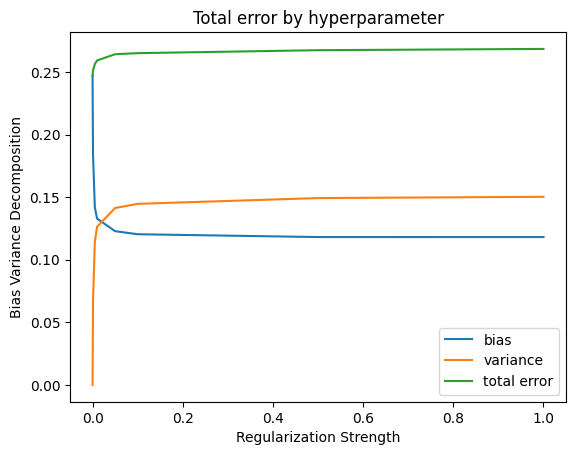

In [77]:
plot_bias_var(bias_C_list,var_C_list,error_C_list,C_list,"Regularization Strength")

From the graph above, it can be seen that there is a tradeoff between the variance and error as we modify the value of C. As C increases, the value the variance increases and the bias decreases. The smallest error was found for the calues of C = 1e-05.

### Justification no scaling normalization

In section 3, no scaling/normalization was needed. As discussed previously, the dataset we are using in our analysis only consists of one hot encoded data 0-1. Hence, there is no need to do any scaling/normalization on the data.

# Question 4 Model Tuning

In this section, we'll use gridsearch to find the best combination of hyperparameter for all models. Multiple hyperparameters exists for LogistcRegression(). The hyperparamters are the following:
- Penalty
- dual
- C
- fit_intercept
- intercept_scaling
- call_weight
- random_state
- solver
- max_iiter
- multi_class
- verbose
- warn_start
- n_job
- L1_ratio

However, Logestic regression does not really have any critical hyperparameter to tune. The following are consider the hyperparameters that could influence the most (solver, penalty, regularizer (C)). Because some solver are not compatible with all penalty, we'll use the solvers and C as hyperparameter and fix the penalty choice to l2 (compatible with all solvers in our case) https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/.

It is too note that accuracy metric is not suitable for our optimization. The accuracy metric is not good when the target is imbalenced https://analyticsindiamag.com/accuracy-isnt-the-best-metric-for-imbalanced-data/. In the initial dataset, the target was already not distributed proportionnally. However, when we create our sub models the target becomes even more disproportionate. For example the table df1314. among the 8136 target values, 7989 are 0. Hence, we will use the target score F-1 which is a preferable score when the targets are imbalanced.

https://www.baeldung.com/cs/multi-class-f1-score#:~:text=The%20F%2D1%20Score%20metric,I%20and%20Type%20II%20errors

In [78]:
# Gridsearch to find best values of C and solver 
#Create train and test for df01
def grid_search_param(df_name,X_train,X_test,y_train,y_test):
    
    model = LogisticRegression(penalty = 'l2')

    # We want to find the best combination of those hyperparameters
    param = {'C':[0.00001,0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1],'solver':['newton-cg','lbfgs','liblinear','sag','saga']}

    model_cv = gridsearch = GridSearchCV(model, param, cv = 10, scoring='f1_weighted')
    model_cv.fit(X_train,y_train)
    best_params = model_cv.best_params_
    print(f"For {df_name}, the results are the following when F1 as the deciding metric:\n")
    print(f"The best parameter is {best_params}")
    print('Best Accuracy Score:', model_cv.score(X_test, y_test))
    print("CV score=%0.3f" % gridsearch.best_score_)
    
    print(best_params)
    return best_params

In [79]:
# Gridsearch for each models

best_param_dict = {}
for d,v in model_dict.items():
    
    X_train, y_train, X_test, y_test = test_train_data(v,'Q29_Encoded') # Call function to split df into train and test  
    best_params = grid_search_param(d,X_train,X_test,y_train,y_test)
    key = d
    best_param_dict[key] = best_params

For m01, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'liblinear'}
Best Accuracy Score: 0.785012285012285
CV score=0.791
{'C': 0.5, 'solver': 'liblinear'}
For m12, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'sag'}
Best Accuracy Score: 0.8060641483848251
CV score=0.808
{'C': 0.5, 'solver': 'sag'}
For m23, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'newton-cg'}
Best Accuracy Score: 0.8207546412328445
CV score=0.835
{'C': 0.5, 'solver': 'newton-cg'}
For m34, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.8251308100616401
CV score=0.836
{'C': 1, 'solver': 'newton-cg'}
For m45, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.

For m01, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'liblinear'}
Best Accuracy Score: 0.785012285012285
CV score=0.791
{'C': 0.5, 'solver': 'liblinear'}
For m12, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'sag'}
Best Accuracy Score: 0.8060641483848251
CV score=0.808
{'C': 0.5, 'solver': 'sag'}
For m23, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'newton-cg'}
Best Accuracy Score: 0.8207546412328445
CV score=0.835
{'C': 0.5, 'solver': 'newton-cg'}
For m34, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.8251308100616401
CV score=0.836
{'C': 1, 'solver': 'newton-cg'}
For m45, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.844096951559149
CV score=0.848
{'C': 1, 'solver': 'newton-cg'}
For m56, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'newton-cg'}
Best Accuracy Score: 0.8489661871936699
CV score=0.859
{'C': 0.5, 'solver': 'newton-cg'}
For m67, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.863431949594305
CV score=0.874
{'C': 1, 'solver': 'newton-cg'}
For m78, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.8844771403005107
CV score=0.889
{'C': 1, 'solver': 'newton-cg'}
For m89, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'liblinear'}
Best Accuracy Score: 0.890369439223328
CV score=0.897
{'C': 1, 'solver': 'liblinear'}
For m910, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'newton-cg'}
Best Accuracy Score: 0.9012794466078462
CV score=0.905
{'C': 0.5, 'solver': 'newton-cg'}
For m1011, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.9289428850843372
CV score=0.920
{'C': 1, 'solver': 'newton-cg'}
For m11, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 1, 'solver': 'newton-cg'}
Best Accuracy Score: 0.9431713763911499
CV score=0.930
{'C': 1, 'solver': 'newton-cg'}
For m1213, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'liblinear'}
Best Accuracy Score: 0.946496017298937
CV score=0.947
{'C': 0.5, 'solver': 'liblinear'}
For m1314, the results are the following when F1 as the deciding metric:

The best parameter is {'C': 0.5, 'solver': 'newton-cg'}
Best Accuracy Score: 0.9788535053159009
CV score=0.973
{'C': 0.5, 'solver': 'newton-cg'}

Using F1 as our deciding score, we obtained the best set of hyperparameters for each models. We also see that as the model increases, the CV score increase. We stored the best hyperparameters of each values in a dictionnary. We will use those values later in our model.

In [80]:
best_param_dict

{'m01': {'C': 0.5, 'solver': 'liblinear'},
 'm12': {'C': 0.5, 'solver': 'sag'},
 'm23': {'C': 0.5, 'solver': 'newton-cg'},
 'm34': {'C': 1, 'solver': 'newton-cg'},
 'm45': {'C': 1, 'solver': 'newton-cg'},
 'm56': {'C': 0.5, 'solver': 'newton-cg'},
 'm67': {'C': 1, 'solver': 'newton-cg'},
 'm78': {'C': 1, 'solver': 'newton-cg'},
 'm89': {'C': 1, 'solver': 'liblinear'},
 'm910': {'C': 0.5, 'solver': 'newton-cg'},
 'm1011': {'C': 1, 'solver': 'newton-cg'},
 'm11': {'C': 1, 'solver': 'newton-cg'},
 'm1213': {'C': 0.5, 'solver': 'liblinear'},
 'm1314': {'C': 0.5, 'solver': 'newton-cg'}}

In [85]:
best_param_list = list(best_param_dict.items())

In [86]:
def best_model(df,show_accuracy = True, show_error = True):
    '''
    Function to output accuracy of each fold of model and its variance. The default values of LogisticRression are used
    but will be tested with different ones. This function loops through each models (14 in our case) in kfold (10 times). 
    For each fold we aggregate the results of all 14 models. The difference between this function and cross_validation
    is that each models has their optimal hyperparameter found just previously. This model also calculates the feature importance
    of each model and aggregates them.
    
    Input:
    model
    show_prediction: Boolean (if set to True, show the predictions for each buckets)
    show_accuracy: Boolean (if set to True, show the accuracy for each folds and the average accuracy)
    '''    
      
    # Initialize values for 10 folds
    accuracy_outcome = []
    bias_outcome = []
    variance_outcome = []
    probability_outcome = [] # Stores probability distribution for each buckets after each fold
    feature_list = [] # Initialise all features
    importance_list = [] # Store importance of all features
    model_count = 0 # Use at the end to divide total importance list
    Initialize = True # Used to initialize feature_list values and importance values
    kfold = 10
    
    for i in range(15):
        probability_outcome.append(0)
    
    
    y_pred_list = np.array([]) # will store all y predictions for each fold
    kf = KFold(n_splits=kfold, shuffle=True, random_state=0)
    number_models = len(model_dict)
    i = 1
    j = 0
    for train_index, test_index in kf.split(df):
        #Initialize values
        fold_accuracy = 0
        fold_bias = 0
        fold_variance = 0
        #Loop through all 14 models and aggregate their averages
        p_prev = 0 # Initiate probability of previous model
        for d,v in model_dict.items():
            
            X = v.drop('Q29_Encoded', axis = 1)
            y = v['Q29_Encoded']
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]   
                       
            if len(np.unique(y_train)) == 1 or len(np.unique(y_test)) == 1: 
            # There's only 1 classification since the distribution is so small hence all the predictions would be perfect
            # Gets an error message if you try to fit model with only 1 classification
                continue               
            else:               
                #Fit the model 
                #Get the best parameter of each model
                
                
                C = best_param_list[j][1]['C']
                solver = best_param_list[j][1]['solver']
                model = LogisticRegression(C=C, solver=solver,penalty = 'l2')    
                
                model.fit(X_train, y_train) #Training the model
                y_pred = model.predict(X_test)
                y_pred_list = np.append(y_pred_list,y_pred)
                  
                # Feature Importance
                importance = model.coef_[0]
                feat_importance = pd.Series(importance)
                
                for index,feature in enumerate(zip(X, feat_importance)):
                    if Initialize == True:
                        feature_list.append(feature[0])
                        importance_list.append(feature[1])                        
                    else:
                        importance_list[index] += feature[1]
                        
                Initialize = False                                               
                    
                                             
                # Calculate probability of 0-1
                p0 = np.count_nonzero(y_pred_list==0)/len(y_pred_list)
                p1 = np.count_nonzero(y_pred_list==1)/len(y_pred_list)
                
                if j == 13:  
                                        
                    probability_dict[str('p'+str(j))] = p0 - p_prev # current probability - total probability of previous one
                    probability_dict['p14'] = p1
                    probability_outcome[j] += probability_dict['p13']
                    probability_outcome[j+1] += probability_dict['p14']
                    
                    # Reset values
                    j, p_prev = 0,0 # Reset both values
                    y_pred_list = np.array([])
                   
                else:                  
                    probability_dict[str('p'+str(j))] = p0 - p_prev # current probability - total probability of previous one
                    probability_outcome[j] += probability_dict[str('p'+str(j))]
                    p_prev = p0                      
                    j += 1             
                  
                #Calculate bias - variance
                bias = bias_fun(y_test,y_pred)
                var = variance_fun(y_pred)          
                #Update values
                fold_accuracy += accuracy_score(y_test, y_pred)
                fold_bias += bias
                fold_variance += var
                model_count +=1   
         
        
        
        if show_accuracy == True:
            print(f"Accuracy for the fold no. {i} using {number_models} on the test set: {(100*(round(fold_accuracy,3)))/number_models} % and its variance is {round((fold_variance/number_models),3)}")
        i += 1
        
        fold_bias = fold_bias / len(model_dict) # take the average of the 14 modles
        fold_variance = fold_variance / len(model_dict)
        
        accuracy_outcome.append(fold_accuracy)
        bias_outcome.append(fold_bias)
        variance_outcome.append(fold_variance)    
        
            
    # Finished computing 10 folds, print results
    
    # Divide importance by model_count (number of time importance was appendended)
    importance_list = list(map(lambda x: x/model_count, importance_list))
    
    
    average_accuracy = np.mean(accuracy_outcome)  # Accuracy
    std_accuracy = np.std(accuracy_outcome)       # Standard deviation  
    bias_average = np.mean(bias_outcome)          # Bias  
    variance_average = np.mean(variance_outcome)  # Variance
    total_error = bias_average + variance_average # Total Error
        
    probability_outcome = np.array(probability_outcome) # converet into array
    probability_outcome = probability_outcome/kfold # Return probability of buckets for 10 folds
    y_pred_list = np.asarray(y_pred_list)
    
    if show_accuracy == True:
        print(f'The average accuracy accross folds is: {(100 * (round(average_accuracy,3)))/number_models} % with a variance of {(round(variance_average,3))} %\n')  
        
        prob_cum = 0 # Use to verify if cumulative probability = 1
        for i, p in enumerate(probability_outcome):
            print(f"The probability of {str('p'+str(i))} is: {p}")
            prob_cum += p
    
        print(f"The cumulative probability is: {prob_cum}")
        
    if show_error == True:
        print(f"The average bias is {round(bias_average,3)}")
        print(f"The average variance is {round(variance_average,3)}")
        print(f"The total average error is {round(total_error,3)}")
    
   
   
    return bias_average, variance_average, total_error, feature_list, importance_list
    

In [87]:
# Plot importance features
bias_average, variance_average, total_error, feature_list, importance_list = best_model(df3_OHE,show_accuracy = True, show_error = True)


Accuracy for the fold no. 1 using 14 on the test set: 88.48571428571428 % and its variance is 0.149
Accuracy for the fold no. 2 using 14 on the test set: 87.54285714285713 % and its variance is 0.146
Accuracy for the fold no. 3 using 14 on the test set: 88.20714285714287 % and its variance is 0.153
Accuracy for the fold no. 4 using 14 on the test set: 88.20714285714287 % and its variance is 0.154
Accuracy for the fold no. 5 using 14 on the test set: 88.64285714285714 % and its variance is 0.15
Accuracy for the fold no. 6 using 14 on the test set: 87.45 % and its variance is 0.156
Accuracy for the fold no. 7 using 14 on the test set: 88.49285714285713 % and its variance is 0.144
Accuracy for the fold no. 8 using 14 on the test set: 87.58571428571429 % and its variance is 0.147
Accuracy for the fold no. 9 using 14 on the test set: 89.25714285714287 % and its variance is 0.149
Accuracy for the fold no. 10 using 14 on the test set: 88.00714285714285 % and its variance is 0.151
The average 

The following are the results of accuracy, bias-variance-error and output predicition when using the optimal hyperparameters based on F1.

- Accuracy for the fold no. 1 using 14 on the test set: 88.48571428571428 % and its variance is 0.149
- Accuracy for the fold no. 2 using 14 on the test set: 87.54285714285713 % and its variance is 0.146
- Accuracy for the fold no. 3 using 14 on the test set: 88.20714285714287 % and its variance is 0.153
- Accuracy for the fold no. 4 using 14 on the test set: 88.20714285714287 % and its variance is 0.154
- Accuracy for the fold no. 5 using 14 on the test set: 88.64285714285714 % and its variance is 0.15
- Accuracy for the fold no. 6 using 14 on the test set: 87.45 % and its variance is 0.156
- Accuracy for the fold no. 7 using 14 on the test set: 88.49285714285713 % and its variance is 0.144
- Accuracy for the fold no. 8 using 14 on the test set: 87.57857142857142 % and its variance is 0.147
- Accuracy for the fold no. 9 using 14 on the test set: 89.25714285714287 % and its variance is 0.149
- Accuracy for the fold no. 10 using 14 on the test set: 88.00714285714285 % and its variance is 0.151
- The average accuracy accross folds is: 88.18571428571428 % with a variation of 0.15 %

- The probability of p0 is: 0.3678762794998957
- The probability of p1 is: 0.06090056846514411
- The probability of p2 is: 0.04795536898857931
- The probability of p3 is: 0.039034266571166945
- The probability of p4 is: 0.035096791692732665
- The probability of p5 is: 0.032022428332391425
- The probability of p6 is: 0.028035329142340214
- The probability of p7 is: 0.025374416564453474
- The probability of p8 is: 0.02250808759111338
- The probability of p9 is: 0.02040316566146827
- The probability of p10 is: 0.020637615902627648
-  The probability of p11 is: 0.01999421351148959
- The probability of p12 is: 0.020321811373471867
- The probability of p13 is: 0.018410724776038456
- The probability of p14 is: 0.24142893192708695
- The cumulatie probability is: 1.0000000000000002
- The average bias is 0.118
- The average variance is 0.15
- The total average error is 0.268

We observe that the change in hyperparameter for each submodels did not have a big impact on the accuracy,the probabilty output, and the bias/variance error. However, this model is model after the best possible F1 score.

## Visualize Feature Importance

In this section, we'll see what are the most important feature (positive and negative importance) after choosing the best hyperparameters.

In [88]:
# Store top 10 positive and negative importance
df_importance = pd.DataFrame({'Feature':feature_list, "Importance": importance_list})
df_importance_positive_importance = df_importance.sort_values(by = 'Importance',ascending=False).head(10)
df_importance_negative_importance = df_importance.sort_values(by = 'Importance').head(10)


In [89]:
df_importance_positive_importance.head()

,Feature,Importance
66,Q4_United States of America,2.775826
13,Q4_Australia,2.115052
35,Q4_Israel,1.877991
18,Q4_Canada,1.377303
65,Q4_United Kingdom of Great Britain and Norther...,1.321358


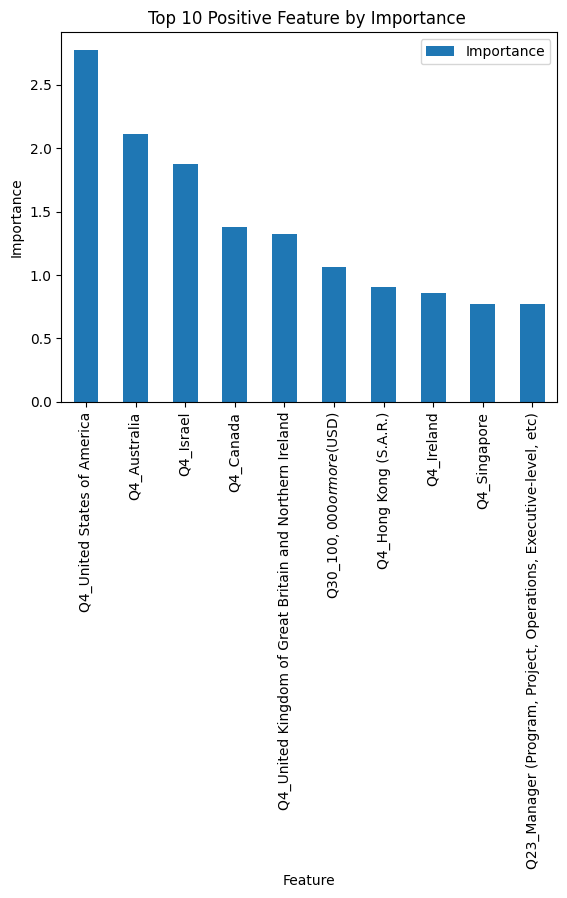

In [90]:
df_importance_positive_importance.plot(x='Feature',y='Importance', kind='bar')
plt.title("Top 10 Positive Feature by Importance ")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

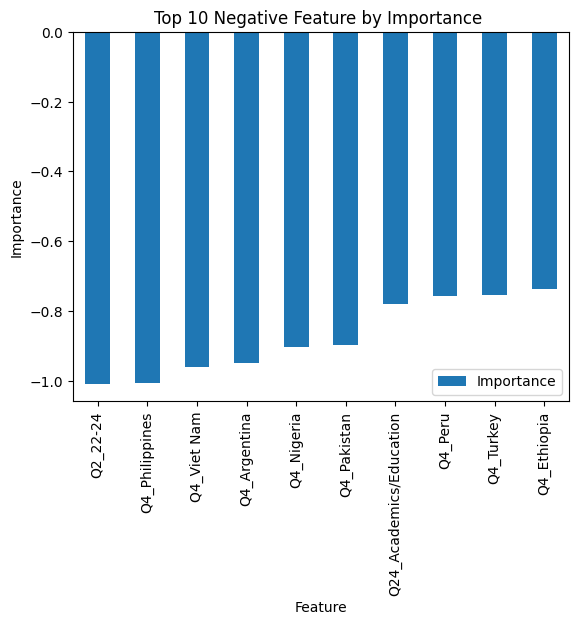

In [91]:
df_importance_negative_importance.plot(x='Feature',y='Importance', kind='bar')
plt.title("Top 10 Negative Feature by Importance ")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

From the results, we can see that the most important features are mostly comming from Q4 (countries). It is intersting since the top 10 negative feature importance also mainly comes from Q4 (countries). When observing the countries in both graphs, we can see that the countries that have a higher score for importancehave higher GPD than the ones with lower importance score.

# 5. Testing & Discussion

In this section, we will use the optimal model to make classifications on the test set and the training set. Determine if it is overfitting or underfitting, plot the distribution of the true target vs the prediction of both training and test set.

In [92]:
def best_model_part5(df,show_accuracy = True, show_error = True, Testing = True):
    '''
    Function to output accuracy ofr each fold of model and its variance. The default values of LogisticRression are used
    but will be tested with different ones.
    
    Input:
    model
    show_prediction: Boolean (if set to True, show the predictions for each buckets)
    show_accuracy: Boolean (if set to True, show the accuracy for each folds and the average accuracy)
    '''    
    if Testing == True:
        print("The following results are on the Test set")
    else:
        print("The following results are on the Training set")
      
    # Initialize values for 10 folds
    accuracy_outcome = []
    bias_outcome = []
    variance_outcome = []
    probability_outcome = [] # Stores probability distribution for each buckets after each fold
    feature_list = [] # Initialise all features
    importance_list = [] # Store importance of all features
    model_count = 0 # Use at the end to divide total importance list
    Initialize = True # Used to initialize feature_list values and importance values
    kfold = 10
    
    for i in range(15):
        probability_outcome.append(0)
    
    
    y_pred_list = np.array([]) # will store all y predictions for each fold
    kf = KFold(n_splits=kfold, shuffle=True, random_state=0)
    number_models = len(model_dict)
    i = 1
    j = 0
    for train_index, test_index in kf.split(df):
        #Initialize values
        fold_accuracy = 0
        fold_bias = 0
        fold_variance = 0
        #Loop through all 14 models and aggregate their averages
        p_prev = 0 # Initiate probability of previous model
        for d,v in model_dict.items():
            
            X = v.drop('Q29_Encoded', axis = 1)
            y = v['Q29_Encoded']
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]   
                       
            if len(np.unique(y_train)) == 1 or len(np.unique(y_test)) == 1: 
            # There's only 1 classification since the distribution is so small hence all the predictions would be perfect
            # Gets an error message if you try to fit model with only 1 classification
                continue               
            else:               
                #Fit the model 
                #Get the best parameter of each model
                
                
                C = best_param_list[j][1]['C']
                solver = best_param_list[j][1]['solver']
                model = LogisticRegression(C=C, solver=solver,penalty = 'l2')    
                
                model.fit(X_train, y_train) #Training the model
                
                if Testing == True:
                    y_pred = model.predict(X_test)
                    y_pred_list = np.append(y_pred_list,y_pred)
                else:
                    y_pred = model.predict(X_train)
                    y_pred_list = np.append(y_pred_list,y_pred)
                  
                # Feature Importance
                importance = model.coef_[0]
                feat_importance = pd.Series(importance)
                
                for index,feature in enumerate(zip(X, feat_importance)):
                    if Initialize == True:
                        feature_list.append(feature[0])
                        importance_list.append(feature[1])                        
                    else:
                        importance_list[index] += feature[1]
                        
                Initialize = False                                               
                    
                                             
                # Calculate probability of 0-1
                p0 = np.count_nonzero(y_pred_list==0)/len(y_pred_list)
                p1 = np.count_nonzero(y_pred_list==1)/len(y_pred_list)
                
                if j == 13:  
                                        
                    probability_dict[str('p'+str(j))] = p0 - p_prev # current probability - total probability of previous one
                    probability_dict['p14'] = p1
                    probability_outcome[j] += probability_dict['p13']
                    probability_outcome[j+1] += probability_dict['p14']
                    
                    # Reset values
                    j, p_prev = 0,0 # Reset both values
                    y_pred_list = np.array([])
                   
                else:                  
                    probability_dict[str('p'+str(j))] = p0 - p_prev # current probability - total probability of previous one
                    probability_outcome[j] += probability_dict[str('p'+str(j))]
                    p_prev = p0                      
                    j += 1             
                  
                if Testing == True:
                    #Calculate bias - variance
                    bias = bias_fun(y_test,y_pred)
                    var = variance_fun(y_pred)          
                    #Update values
                    fold_accuracy += accuracy_score(y_test, y_pred)
                    
                else:
                   #Calculate bias - variance
                    bias = bias_fun(y_train,y_pred)
                    var = variance_fun(y_pred)          
                    #Update values
                    fold_accuracy += accuracy_score(y_train, y_pred) 
                    
                fold_bias += bias
                fold_variance += var
                model_count +=1   
         
        
        
        if show_accuracy == True and Testing == True:
            print(f"Accuracy for the fold no. {i} using {number_models} on the testing set: {(100*(round(fold_accuracy,3)))/number_models} %")
        
        elif show_accuracy == True and Testing == False:
            print(f"Accuracy for the fold no. {i} using {number_models} on the training set: {(100*(round(fold_accuracy,3)))/number_models} %")
        
        i += 1
        
        fold_bias = fold_bias / len(model_dict) # take the average of the 14 modles
        fold_variance = fold_variance / len(model_dict)
        
        accuracy_outcome.append(fold_accuracy)
        bias_outcome.append(fold_bias)
        variance_outcome.append(fold_variance)    
        
            
    # Finished computing 10 folds, print results
    
    # Divide importance by model_count (number of time importance was appendended)
    importance_list = list(map(lambda x: x/model_count, importance_list))
    
    
    average_accuracy = np.mean(accuracy_outcome)  # Accuracy
    std_accuracy = np.std(accuracy_outcome)       # Standard deviation  
    bias_average = np.mean(bias_outcome)          # Bias  
    variance_average = np.mean(variance_outcome)  # Variance
    total_error = bias_average + variance_average # Total Error
        
    probability_outcome = np.array(probability_outcome) # converet into array
    probability_outcome = probability_outcome/kfold # Return probability of buckets for 10 folds
    y_pred_list = np.asarray(y_pred_list)
    
    if show_accuracy == True:
        print(f'The average accuracy accross folds is: {round((100*(average_accuracy)),3)/number_models} % with a variance of {(round(variance_average,3))}\n')  
        
        prob_cum = 0 # Use to verify if cumulative probability = 1
        for i, p in enumerate(probability_outcome):
            print(f"The probability of {str('p'+str(i))} is: {p}")
            prob_cum += p
    
        print(f"The cumulative probability is: {prob_cum}")
        
    if show_error == True:
        print(f"The average bias is {round(bias_average,3)}")
        print(f"The average variance is {round(variance_average,3)}")
        print(f"The total average error is {round(total_error,3)}")
    
   
   
    return bias_average, variance_average, total_error, probability_outcome
    

In [93]:
# Getting results for the test set
bias_average, variance_average, total_error, probability_outcome_test = best_model_part5(df3_OHE,show_accuracy = True, show_error = True, Testing = True)

The following results are on the Test set
Accuracy for the fold no. 1 using 14 on the testing set: 88.48571428571428 %
Accuracy for the fold no. 2 using 14 on the testing set: 87.54285714285713 %
Accuracy for the fold no. 3 using 14 on the testing set: 88.20714285714287 %
Accuracy for the fold no. 4 using 14 on the testing set: 88.20714285714287 %
Accuracy for the fold no. 5 using 14 on the testing set: 88.64285714285714 %
Accuracy for the fold no. 6 using 14 on the testing set: 87.45 %
Accuracy for the fold no. 7 using 14 on the testing set: 88.49285714285713 %
Accuracy for the fold no. 8 using 14 on the testing set: 87.57857142857142 %
Accuracy for the fold no. 9 using 14 on the testing set: 89.25714285714287 %
Accuracy for the fold no. 10 using 14 on the testing set: 88.00714285714285 %
The average accuracy accross folds is: 88.18664285714286 % with a variance of 0.15

The probability of p0 is: 0.3678762794998957
The probability of p1 is: 0.06090056846514411
The probability of p2 is

The following results are on the Test set
- Accuracy for the fold no. 1 using 14 on the testing set: 88.48571428571428 %
- Accuracy for the fold no. 2 using 14 on the testing set: 87.52857142857142 %
- Accuracy for the fold no. 3 using 14 on the testing set: 88.20714285714287 %
- Accuracy for the fold no. 4 using 14 on the testing set: 88.20714285714287 %
- Accuracy for the fold no. 5 using 14 on the testing set: 88.64285714285714 %
- Accuracy for the fold no. 6 using 14 on the testing set: 87.45714285714287 %
- Accuracy for the fold no. 7 using 14 on the testing set: 88.47857142857143 %
- Accuracy for the fold no. 8 using 14 on the testing set: 87.57857142857142 %
- Accuracy for the fold no. 9 using 14 on the testing set: 89.25714285714287 %
- Accuracy for the fold no. 10 using 14 on the testing set: 88.00714285714285 %
- The average accuracy accross folds is: 88.18571428571428 % with a variance of 0.15

- The probability of p0 is: 0.3678762794998957
- The probability of p1 is: 0.06108491920300039
- The probability of p2 is: 0.04789391874262722
- The probability of p3 is: 0.03900354144819091
- The probability of p4 is: 0.035078356618947024
- The probability of p5 is: 0.032010138283201005
- The probability of p6 is: 0.02802655053577563
- The probability of p7 is: 0.025367832609530037
- The probability of p8 is: 0.022502966737284046
- The probability of p9 is: 0.0203990689784048
- The probability of p10 is: 0.02063426407103024
- The probability of p11 is: 0.01999142031849178
- The probability of p12 is: 0.020319447902473718
- The probability of p13 is: 0.01840869894375431
- The probability of p14 is: 0.24140259610739312
- The cumulative probability is: 0.9999999999999999
- The average bias is 0.118
- The average variance is 0.15
- The total average error is 0.268

In [94]:
# Getting results for the training set
bias_average, variance_average, total_error, probability_outcome_training = best_model_part5(df3_OHE,show_accuracy = True, show_error = True, Testing = False)

The following results are on the Training set
Accuracy for the fold no. 1 using 14 on the training set: 88.85000000000001 %
Accuracy for the fold no. 2 using 14 on the training set: 88.89999999999999 %
Accuracy for the fold no. 3 using 14 on the training set: 88.82857142857142 %
Accuracy for the fold no. 4 using 14 on the training set: 88.82857142857142 %
Accuracy for the fold no. 5 using 14 on the training set: 88.79285714285713 %
Accuracy for the fold no. 6 using 14 on the training set: 88.85000000000001 %
Accuracy for the fold no. 7 using 14 on the training set: 88.78571428571429 %
Accuracy for the fold no. 8 using 14 on the training set: 88.82142857142857 %
Accuracy for the fold no. 9 using 14 on the training set: 88.71428571428571 %
Accuracy for the fold no. 10 using 14 on the training set: 88.8142857142857 %
The average accuracy accross folds is: 88.81885714285714 % with a variance of 0.15

The probability of p0 is: 0.3659866727107921
The probability of p1 is: 0.06189224302293108

The following results are on the Training set
- Accuracy for the fold no. 1 using 14 on the training set: 88.85000000000001 %
- Accuracy for the fold no. 2 using 14 on the training set: 88.89999999999999 %
- Accuracy for the fold no. 3 using 14 on the training set: 88.82857142857142 %
- Accuracy for the fold no. 4 using 14 on the training set: 88.82857142857142 %
- Accuracy for the fold no. 5 using 14 on the training set: 88.79285714285713 %
- Accuracy for the fold no. 6 using 14 on the training set: 88.85000000000001 %
- Accuracy for the fold no. 7 using 14 on the training set: 88.78571428571429 %
- Accuracy for the fold no. 8 using 14 on the training set: 88.82142857142857 %
- Accuracy for the fold no. 9 using 14 on the training set: 88.71428571428571 %
- Accuracy for the fold no. 10 using 14 on the training set: 88.8142857142857 %
- The average accuracy accross folds is: 88.81857142857143 % with a variance of 0.15

- The probability of p0 is: 0.3659866727107921
- The probability of p1 is: 0.06188541428761285
- The probability of p2 is: 0.04789641195511905
- The probability of p3 is: 0.03964661056939399
- The probability of p4 is: 0.03516127378415035
- The probability of p5 is: 0.03212196840550655
- The probability of p6 is: 0.028264533084548783
- The probability of p7 is: 0.025437109964062267
- The probability of p8 is: 0.02244140997006422
- The probability of p9 is: 0.02038265940003937
- The probability of p10 is: 0.020472050407580523
- The probability of p11 is: 0.020044034597799833
- The probability of p12 is: 0.020352457061730923
- The probability of p13 is: 0.01844970767014472
- The probability of p14 is: 0.24145768613145444
- The cumulative probability is: 0.9999999999999999
- The average bias is 0.112
- The average variance is 0.15
- The total average error is 0.262

Comparing the accuracy of the training vs testing, we can see whether the model is underfitting or overfitting. Both accurracies are fairly similar (around 88.1 testing vs 88.8 training%), which is a decent accuracy. We can say the model is pretty balanced and not really over or underfitting by much. Also the total bias/variance error of the test is slightly higher than the training bias/variance error.

## Plotting distribution of actual target, test prediction, training prediction 

In [95]:
# We want to see the distribution of the target.

# Original Dataset
target = [] # target of original dataset
target_count_original = [] # distribution of original target's dataset

total_rows = len(df2)
for i in df2['Q29_Encoded'].unique():
    target.append(i)
    target_count_original.append((df2['Q29_Encoded'].value_counts()[i])/total_rows)
    
target = [int(x) for x in target] # Convert to int (helps for later steps)

# We know the probabilities for training and testing were in ascending order.
target_result = [] 
for i in range(15):
    target_result.append(i)

target_count_test = probability_outcome_test
target_count_training = probability_outcome_training

In [96]:
# Create data frame 
df_original_dist = pd.DataFrame({'target':target, "distribution original": target_count}) # Create table for original distribution
df_testing_dist = pd.DataFrame({'target':target_result, "distribution test set": target_count_test})
df_training_dist = pd.DataFrame({'target':target_result, "distribution train set": target_count_training})

In [97]:
# Merge tables together 
df_target_distribution = df_original_dist.merge(df_testing_dist, how='inner', on = 'target')
df_target_distribution = df_target_distribution.merge(df_training_dist, how='inner', on = 'target')
df_target_distribution = df_target_distribution.sort_values('target')


<AxesSubplot:title={'center':'Target Distribution'}, xlabel='target', ylabel='Distribution %'>

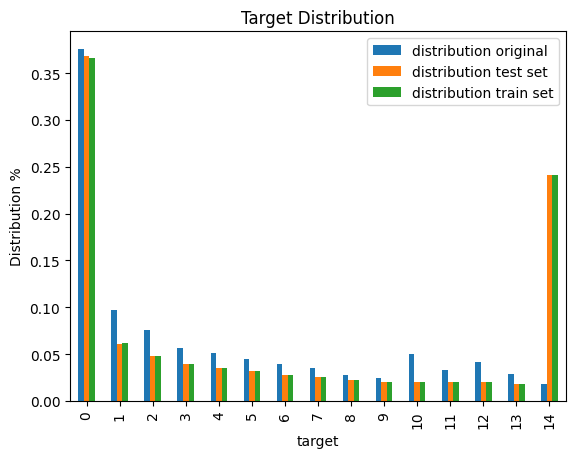

In [98]:
df_target_distribution.plot(x="target",y=['distribution original',
                            'distribution test set','distribution train set'],
                            kind='bar',title='Target Distribution', ylabel='Distribution %')


Our result illustrates that the prediction for each target under estimates a bit excpet bucket 14 which they overestimated by a lot. This would definitly be an area for improvement.